In [8]:
import addons
import numpy as np
import pandas as pd 
import os
import helpers
import random
import math
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation

In [9]:
def filter_signal(data,fs,lowcut,highcut,order=3):
    filtered_signal = {}
    for i in data:
        filtered_signal[i] = addons.butter_bandpass_filter(data[i][addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]]-np.mean(data[i][addons.analysis_dict["analysis_start"]:addons.analysis_dict["analysis_end"]]),lowcut,highcut,fs,order)

    return filtered_signal

In [10]:
def filter_signal_2(data,fs,lowcut,highcut,order=3):
      return addons.butter_bandpass_filter(data-np.mean(data),lowcut,highcut,fs,order)

  

In [11]:
import math 
from scipy.fftpack import *

def hilbert_transform(signal):
    '''
    N : fft length
    M : number of elements to zero out
    U : DFT of signal
    V: IDFT of H(U) 
    '''

    N = len(signal)
    #take the forward Fourier transform
    U = fft(signal)
    M = N - N//2 - 1
    #Zero out negative frequency components
    U[N//2+1:] = [0] * M 
    #double fft energy except #DC0
    U[1:N//2] = 2 * U[1:N//2]
    #take inverse of Fourier transform
    v = ifft(U)
    return v 

In [12]:
def analyse_synchrony(num_neurons,name,bin_width=3,t_r = 2,dt=0.01):
    analysis_interval_start = addons.analysis_dict["analysis_start"]
    analysis_interval_end = addons.analysis_dict["analysis_end"]
    analysis_interval_start_s = addons.analysis_dict["synchrony_start"]
    analysis_interval_end_s = addons.analysis_dict["synchrony_end"]
    
    
    analysis_length = analysis_interval_end - analysis_interval_start
    analysis_length_s = analysis_interval_end_s - analysis_interval_start_s
    pop_activity = {}
    if analysis_length - analysis_length_s < 0:
        print('There is a problem. Synchrony measurement range must be smaller than the other')
        return 

    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",analysis_interval_start_s, analysis_interval_end_s)
    
    helper = np.loadtxt(name+"measurements/pop_activities/pop_activity_"+str(0)+".dat")
    sum_array = np.zeros_like(helper)
    for i in range(len(num_neurons)):
        pop_activity[i] = np.loadtxt(name+"measurements/pop_activities/pop_activity_"+str(i)+".dat")
        sum_array = sum_array + pop_activity[i]

    data_s = {}

    for i in data:
        low = np.searchsorted(data[i]["time_ms"],v=analysis_interval_start_s,side="left")
        high = np.searchsorted(data[i]["time_ms"],v=analysis_interval_end_s,side='right')
        data_s[i] = data[i][low:high]


    synchrony_pd = []
    synchrony_chi = []
    irregularity = []
    irregularity_pdf = {}

    super_lvr = []
    lvr_pdf = {}

    times_s = {}

    for i, n in enumerate(sd_names):

        #Computing synchrony
        neurons = np.unique(data_s[i]["sender"])
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data_s[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_s[i] = data_s[i][indices]["time_ms"]
        counts, bins = np.histogram(times_s[i], bins=int(analysis_length_s/bin_width))
        counts2, bins = np.histogram(times_s[i], bins=int(analysis_length_s/bin_width/2))
    
        synchrony_chi = np.append(synchrony_chi,np.var(counts2)/np.mean(counts2)) 
        synchrony_pd = np.append(synchrony_pd,np.var(counts)/np.mean(counts))

        #Computing irregularity and LvR
        single_irregularity = []
        used_senders = []
        single_lvr = 0
        lvr = []

    mean_pop = sum_array / len(num_neurons)
    sum = 0
    for i, n in enumerate(pop_activity):
        sum = sum + np.var(pop_activity[i])
    chi = np.var(mean_pop) / ((1 / len(num_neurons)) * sum)

    
    for i,n in enumerate(sd_names):
        single_irregularity = []
        used_senders = []
        single_lvr = 0
        lvr = []
        for senders in data[i]["sender"]:
            individual_neurons = []
            times = []
            isi = []
            count = 0
            if senders not in used_senders:
                used_senders = np.append(used_senders,senders)
                individual_neurons = np.append(individual_neurons,np.where(data[i]["sender"]==senders))
                for index in individual_neurons:
                    times = np.append(times,data[i][int(index)]["time_ms"])

                if len(times)>4:
                    for j in range(len(times)-1):
                        isi = np.append(isi,times[j+1]-times[j])
                    for j in range(len(isi)-1):
                        single_lvr = single_lvr +  (1 - 4*isi[j]*isi[j+1] / (isi[j]+isi[j+1])**2) * (1 + 4 * t_r / (isi[j] + isi[j+1]))

                    neuron_rate = len(times) / analysis_length * 1000

                    single_lvr = 3 / (len(isi)-1) * single_lvr
                    lvr = np.append(lvr, single_lvr)
                    mean =np.mean(isi)
                    var = np.sqrt(np.var(isi))
                    single_irregularity = np.append(single_irregularity,np.float128(var/mean))
                    count = count + 1    
                if count >= 1000:
                    break
        super_lvr = np.append(super_lvr, np.mean(lvr))
        
        lvr_pdf[i] = lvr
        if np.mean(single_irregularity)==None:
            irregularity = np.append(irregularity,0)
        else:
            irregularity = np.append(irregularity,np.mean(single_irregularity))
            irregularity_pdf[i] = single_irregularity

    

    #super_lvr = super_lvr[~np.isnan(super_lvr)]
    #irregularity = irregularity[~np.isnan(irregularity)] 
 
    return synchrony_pd, synchrony_chi, irregularity, irregularity_pdf, super_lvr, lvr_pdf, times_s, chi 


In [13]:
def plot_synchrony(synchrony_pd, synchrony_chi, irregularity, irregularity_pdf, lvr, lvr_pdf,chi, name):

    a = plt.figure(figsize=(18,18))

#####################################################################################################################
    pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
    colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    fs = 18
    medianprops = dict(linestyle="-", linewidth=2.5, color="black")
    meanprops = dict(linestyle="--", linewidth=2.5, color="darkgray")

    plt.subplot(3, 2, 1)
    plt.barh(pops[::-1], synchrony_pd[::-1], color = colours[::-1])
    plt.xlabel('synchrony', fontsize = fs)
    plt.grid(alpha = 0.5)

#####################################################################################
    plt.subplot(3, 2, 2)
    plt.barh(pops[::-1], synchrony_chi[::-1], color = colours[::-1])
    #plt.ylabel('populations', fontsize = fs)
    plt.title(r'$\chi$ =('+str(round(chi,3))+')', fontsize = fs)
    plt.xlabel('synchrony with half bin size', fontsize = fs)
    plt.grid(alpha = 0.5)


###########################################################################################################################
    plt.subplot(3,2,3)
    test = []
    colours_box = ['#3288bd','#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    pops_box = pops
    j = 0
    label_pos = list(range(len(pops_box),0,-1))
    for i in np.arange(len(pops)):
        if len(irregularity_pdf[i]) == 0: 
            del pops_box[i-j]
            j = j+1
        else:
            test.append(irregularity_pdf[i])
    bp = plt.boxplot(test, 0, "rs",0,medianprops=medianprops,meanprops=meanprops, meanline=True, showmeans=True,orientation='horizontal')
    label_pos = list(range(len(pops_box), 0, -1))
    if len(pops) != len(pops_box):
        colours_box = ['#3288bd', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    for i in np.arange(len(pops_box)):
        boxX = []
        boxY = []
        box = bp["boxes"][i]
        for j in list(range(5)):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))
        boxPolygon = Polygon(boxCoords, facecolor=colours_box[-i])
        plt.gca().add_patch(boxPolygon)
    plt.xlabel('irregulatiry', fontsize = fs)
    plt.yticks(label_pos, pops_box, fontsize=fs)
    plt.grid(alpha = 0.5)

############################################################################################################
    plt.subplot(3,2,4)
    pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
    colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    colours_pdf = list(reversed(colours))
    pops_pdf = list(reversed(pops))
    irregularity_total = []
    for i in irregularity_pdf:
        data, bins= np.histogram(irregularity_pdf[i],density=True,bins=50)
        irregularity_total = np.append(irregularity_total,irregularity_pdf[i])
        plt.plot(bins[:-1],data,alpha=0.3+i*0.1, label = pops_pdf[i], color = colours_pdf[i])

    data_t, bins_s = np.histogram(irregularity_total,density=True,bins=50)
    plt.plot(bins[:-1],data_t, label = 'Total', color = 'black', ls = 'dashed')
   
    plt.legend()
    plt.ylabel('P (irregularity)', fontsize = fs)
    plt.xlabel('CV ISI', fontsize = fs)
    plt.grid(alpha = 0.5)
    plt.xlim(0,1.8)
    plt.ylim(0,3.6)

######################################################################################################################
    plt.subplot(3,2,5)
    
    colours_box = ['#3288bd','#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    pops_box = pops
    test = []
    j = 0
    for i in np.arange(len(pops)):
        if len(lvr_pdf[i]) == 0: 
            del pops_box[i-j]
            j = j+1
        else:
            test.append(lvr_pdf[i])
    bp = plt.boxplot(test, 0, "rs",0,medianprops=medianprops,meanprops=meanprops, meanline=True, showmeans=True,orientation='horizontal')
    if len(pops) != len(pops_box):
        colours_box = ['#3288bd', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5']
    label_pos = list(range(len(pops_box), 0, -1))
    for i in np.arange(len(pops_box)):
        boxX = []
        boxY = []
        box = bp["boxes"][i]
        for j in list(range(5)):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
        boxCoords = list(zip(boxX, boxY))
        k = i % 2
        boxPolygon = Polygon(boxCoords, facecolor=colours_box[-i])
        plt.gca().add_patch(boxPolygon)
    #plt.title('LvR')
    plt.yticks(label_pos, pops_box, fontsize=fs)
    plt.xlabel('LvR', fontsize = fs)
    plt.grid(alpha = 0.5)

##########################################################################################################################################
    plt.subplot(3,2,6)
    lvr_total = []
    for i in lvr_pdf:
        data, bins= np.histogram(lvr_pdf[i],density=True)
        lvt_total = np.append(lvr_total,lvr_pdf[i])
        if math.isnan(data[0]) == False:
            plt.plot(bins[:-1],data,alpha=0.3+i*0.1, label = pops_pdf[i], color = colours_pdf[i])

    data_t, bins_s = np.histogram(lvr_total,density=True)
    plt.plot(bins[:-1],data_t, label = 'Total', color = 'black', ls = 'dashed')
    plt.grid(alpha = 0.5)
    plt.legend()
    plt.ylabel('P (LvR)', fontsize = fs)
    #plt.title('P (LvR)')
    plt.xlim(0,8)
    plt.ylim(0,2.1)
    plt.xlabel('LvR', fontsize =fs)

    if os.path.isdir(name) == False:
        os.mkdir(name)
        
    plt.suptitle(str(name))
    plt.tight_layout()
    plt.savefig(name + "test_synchrony.svg", dpi=300)
    plt.close()



In [14]:
list_dirs = os.listdir("data_background_rate")
list_dirs = sorted(list_dirs)
ims = []
fig  = plt.figure(figsize=(16,16))
for i, dir in enumerate(list_dirs):
    name = "data_background_rate/" + str(dir)
    neuron_id = np.loadtxt((os.path.join(name,"population_nodeids.dat")),dtype=int)
    num_neurons = []
    for j in range(len(neuron_id)):
        num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
    num_neurons = num_neurons.astype(int)
    #Correctly reading the number of neurons
    name = "data_background_rate/" + str(dir) + "/"
    synchrony_pd, synchrony_chi, irregularity, irregularity_pdf, lvr, lvr_pdf, times_s, chi = analyse_synchrony(num_neurons,name)

    plot_synchrony(synchrony_pd,synchrony_chi,irregularity,irregularity_pdf,lvr,lvr_pdf, chi, name + "results/")
    name = name + 'results/'


    if not os.path.isdir(name):
        os.mkdir(name)


    np.savetxt(name + "synchrony.dat",synchrony_pd)
    np.savetxt(name + "irregularity.dat",irregularity)
    np.savetxt(name + "lvr.dat",lvr)



    if not os.path.isdir(name+"irregularities/"):
        os.mkdir(name+"irregularities/")
    if not os.path.isdir(name+"lvrs/"):
        os.mkdir(name+"lvrs/")
    if not os.path.isdir(name+"times/"):
        os.mkdir(name+"times/")

    for i in irregularity_pdf:
        np.savetxt(name + "irregularities/irregularity_"+str(i)+".dat",irregularity_pdf[i])
    for i in lvr_pdf:
        np.savetxt(name + "lvrs/lvr_"+str(i)+".dat",lvr_pdf[i])
    for i in times_s:
        np.savetxt(name + "times/time_"+str(i)+".dat",times_s[i])


/home/hyc_1/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:Mean of empty slice.
/home/hyc_1/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide
/tmp/ipykernel_454095/3651649482.py:39: MatplotlibDeprecationWarning:Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
/home/hyc_1/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:invalid value encountered in divide
/tmp/ipykernel_454095/3651649482.py:92: MatplotlibDeprecationWarning:Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
/home/hyc_1/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:invalid value encountered in divide
/tmp/ipykernel_454095/3651649482.py:39: MatplotlibDeprecationWarning:Passing the

Abort is in progress...hit ctrl-c again within 5 seconds to forcibly terminate



KeyboardInterrupt: 

<Figure size 1152x1152 with 0 Axes>

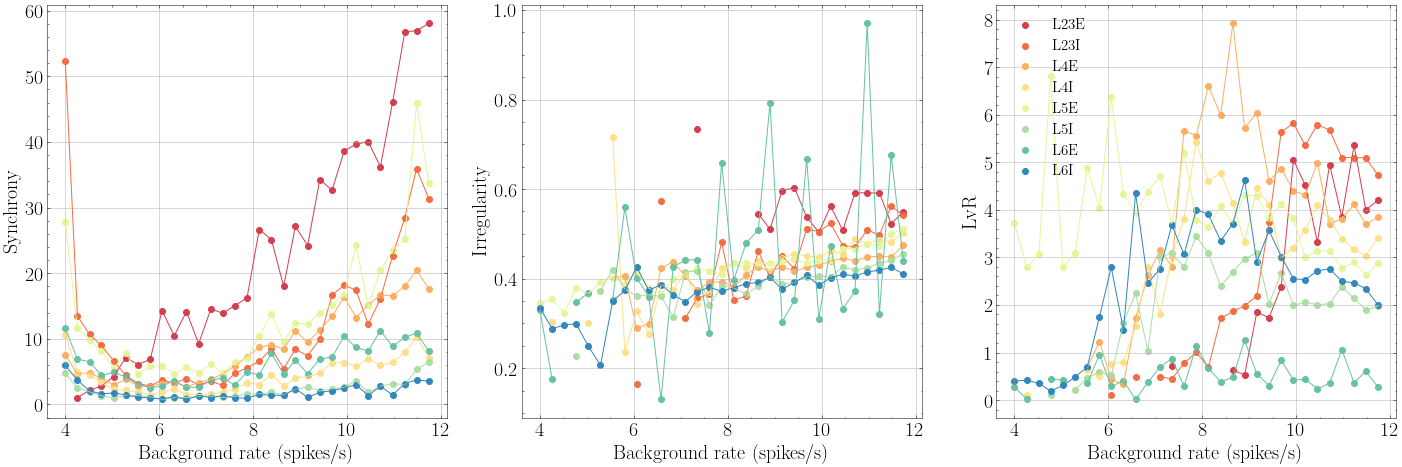

In [ ]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams.update({'font.size': 20})

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']

list_dirs = os.listdir("data_background_rate")
list_dirs = sorted(list_dirs)
del list_dirs[-1]


synchrony = np.zeros((len(list_dirs),len(names)))
irregularity = np.zeros((len(list_dirs),len(names)))
lvr = np.zeros((len(list_dirs),len(names)))

xlabels = np.zeros(len(list_dirs))

for i in range(len(list_dirs)):
    synchrony[i][:] = np.loadtxt("data_background_rate/"+list_dirs[i]+"/results/synchrony.dat")
    irregularity[i][:] = np.loadtxt("data_background_rate/" + list_dirs[i]+"/results/irregularity.dat")
    lvr[i][:] = np.loadtxt("data_background_rate/" + list_dirs[i]+"/results/lvr.dat")
    xlabels[i] = float(list_dirs[i])
synchrony = np.transpose(synchrony)
irregularity = np.transpose(irregularity)
lvr = np.transpose(lvr)


plt.figure(figsize=(20,7))
plt.subplot(1,3,1)

for i in range(len(synchrony[:])):
    plt.scatter(xlabels,synchrony[i][:],label=names[i],color=colours[i])
    plt.plot(xlabels,synchrony[i][:],color=colours[i])

plt.xlabel('Background rate (spikes/s)')
plt.ylabel("Synchrony")
#plt.legend(fontsize=15)
plt.grid()
#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of background rate")

plt.subplot(1,3,2)

for i in range(len(irregularity[:])):
    plt.scatter(xlabels,irregularity[i][:],label=names[i],color=colours[i])
    plt.plot(xlabels,irregularity[i][:],color=colours[i])

plt.xlabel('Background rate (spikes/s)')
plt.ylabel("Irregularity")
#plt.legend(fontsize=15)
plt.grid()

plt.subplot(1,3,3)

for i in range(len(lvr[:])):
    plt.scatter(xlabels,lvr[i][:],label=names[i],color=colours[i])
    plt.plot(xlabels,lvr[i][:],color=colours[i])

plt.xlabel('Background rate (spikes/s)')
plt.ylabel("LvR")
plt.legend(fontsize=15)
plt.grid()
#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of refractory period")
plt.tight_layout()
plt.show()

/tmp/ipykernel_450893/1526558191.py:20: UserWarning:loadtxt: input contained no data: "data_background_rate/04.52/results/irregularities/irregularity_6.dat"
/tmp/ipykernel_450893/1526558191.py:21: UserWarning:loadtxt: input contained no data: "data_background_rate/04.52/results/lvrs/lvr_6.dat"
/tmp/ipykernel_450893/1526558191.py:20: UserWarning:loadtxt: input contained no data: "data_background_rate/05.29/results/irregularities/irregularity_6.dat"
/tmp/ipykernel_450893/1526558191.py:21: UserWarning:loadtxt: input contained no data: "data_background_rate/05.29/results/lvrs/lvr_6.dat"


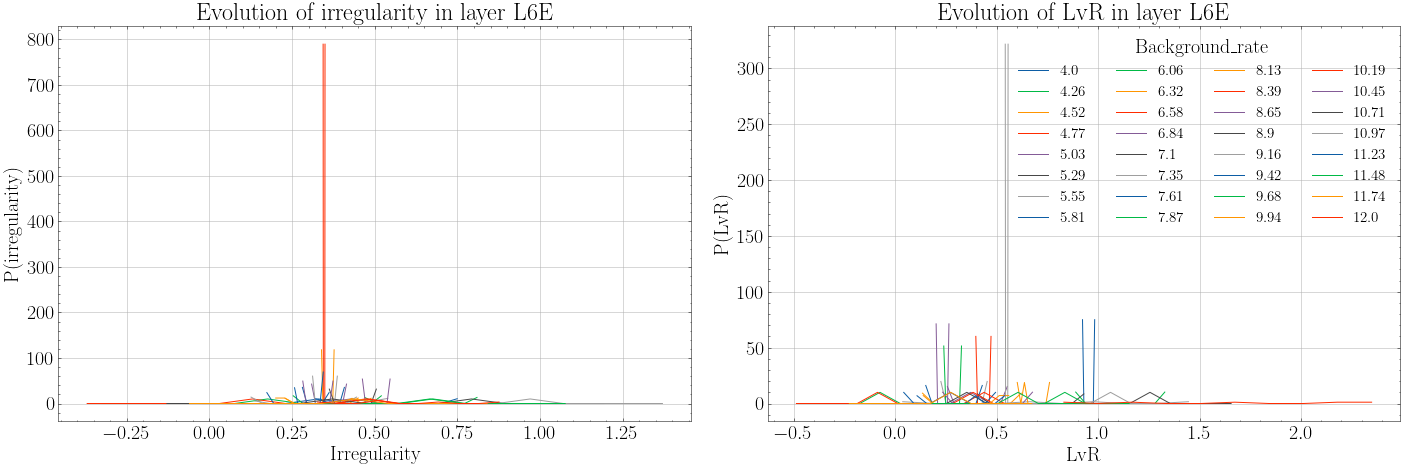

In [9]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams.update({'font.size': 20})

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']

list_dirs = os.listdir("data_background_rate")
list_dirs = sorted(list_dirs)


irregularity = {}
lvr = {}

xlabels = np.zeros(len(list_dirs))

layer_of_interest= 6

for i in range(len(list_dirs)):
    irregularity[i] = np.loadtxt("data_background_rate/"+list_dirs[i]+"/results/irregularities/irregularity_"+str(layer_of_interest)+".dat")
    lvr[i] = np.loadtxt("data_background_rate/"+list_dirs[i]+"/results/lvrs/lvr_"+str(layer_of_interest)+".dat")


    xlabels[i] = float(list_dirs[i])




plt.figure(figsize=(20,7))
plt.subplot(1,2,1)

for i in irregularity:
    data, bins= np.histogram(irregularity[i],density=True)
    plt.plot(bins[:-1],data, label = xlabels[i])

plt.xlabel('Irregularity')
plt.ylabel("P(irregularity)")
#plt.legend(fontsize=15,title='Background_rate')
plt.title('Evolution of irregularity in layer ' + names[layer_of_interest])
plt.grid()


plt.subplot(1,2,2)

for i in lvr:
    data, bins= np.histogram(lvr[i],density=True)
    plt.plot(bins[:-1],data, label = xlabels[i])

plt.xlabel('LvR')
plt.ylabel("P(LvR)")
plt.legend(fontsize=15,title='Background_rate',ncols=4)
plt.title('Evolution of LvR in layer ' + names[layer_of_interest])
plt.grid()
plt.tight_layout()

In [9]:

list_dirs = os.listdir("data_background_rate")
list_dirs = sorted(list_dirs)


pop_activity = {}
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

       
for i, dir in enumerate(list_dirs):
    name = "data_background_rate/" + str(dir)
    neuron_id = np.loadtxt((os.path.join(name,"population_nodeids.dat")),dtype=int)
    num_neurons = []
    for l in range(len(neuron_id)):
        num_neurons = np.append(num_neurons,int(neuron_id[l][1]-neuron_id[l][0]+1))
    num_neurons = num_neurons.astype(int)
    pop_activity[dir] = {}
    for j in range(len(num_neurons)):
        pop_activity[dir][j] = np.loadtxt(name+"/measurements/pop_activities/pop_activity_"+str(j)+".dat")

In [10]:
from scipy.sparse import dok_matrix 
from scipy.fft import fft
from scipy.fft import fftfreq
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def compute_FFT(signal_data,name_,rate,freq_sample= 0.001,freq_sample_welsh = 1000,lim_y = 7000, lim_x = 200, low_log = 10, high_log =90,fit=False,fit_freq_start = 4.0, fit_freq_end = 14.0,test_p0 = [30,10,5],welsh_fit = 'alpha',signal_xmin=500,signal_xmax=900,min_x=1,save=True):

    analysis_interval_start = addons.analysis_dict["analysis_start"]
    analysis_interval_end = addons.analysis_dict["analysis_end"]
    FFT_Results = {}
    Welsh_Freqs = {}
    Welsh_Powers = {}
    if fit:
        Fit_FFT = {}
        Fit_Welsh = {}
        mean_freq = []
        mean_welsh = []
        amplitude_freq = []
        amplitude_welsh = []
        sigma_freq = []
        sigma_welsh = []
        def gaus(x, a, x0, sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    for i in signal_data:
        FFT_Results[i] = fft(signal_data[i][analysis_interval_start:analysis_interval_end]-np.mean(signal_data[i][analysis_interval_start:analysis_interval_end]))
        Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(signal_data[i][analysis_interval_start:analysis_interval_end]-np.mean(signal_data[i][analysis_interval_start:analysis_interval_end]),fs=freq_sample_welsh)

    #Calcular los valores de frequencia correspondientes
    #freq = fftfreq(len(signal_data[i][analysis_interval_start:analysis_interval_end]),d=freq_sample) * 1000
    freq = fftfreq(len(signal_data[i][analysis_interval_start:analysis_interval_end]),d=freq_sample)
    if fit:
        index_start = int(np.where(freq==fit_freq_start)[0][0])
        index_end = int(np.where(freq==fit_freq_end)[0][0])
    

    plt.figure(figsize=(25, 15))
    colors = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    pops = ["L23E","L23I","L4E","L4I","L5E","L5I","L6E","L6I"]
    # Graficar la amplitud en función de la frecuencia

    plt.subplot(2, 1, 1)
    j= 0
    for i in signal_data:
        plt.plot(signal_data[i][analysis_interval_start:analysis_interval_end+700], c = colors[j], label = pops[i])
        j=j+1
    plt.xlabel('Time (ms)')
    plt.ylabel('Signal')
    plt.title('Signal, background rate = ' +str(rate))
    plt.xlim(signal_xmin,signal_xmax)    
    plt.grid(True)
    #plt.legend(loc= 'best')
    plt.legend(loc= 'upper left')
    plt.subplot(2, 3, 4)
    j= 0

    indx = int(len(signal_data[i][analysis_interval_start:analysis_interval_end])/2)
    for i in FFT_Results:
        if fit:
            Fit_FFT[i], __ = curve_fit(gaus,freq[index_start:index_end],np.abs(FFT_Results[i][index_start:index_end]),p0 = test_p0)
            mean_freq = np.append(mean_freq,Fit_FFT[i][1])
            amplitude_freq = np.append(amplitude_freq,Fit_FFT[i][0])
            sigma_freq = np.append(sigma_freq,Fit_FFT[i][2])

            plt.plot(freq[index_start:index_end],gaus(freq[index_start:index_end],*Fit_FFT[i]),'--', c = colors[j])
        plt.plot(freq[:indx], np.abs(FFT_Results[i])[:indx],c = colors[j], label = pops[i])
        j=j+1
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.figtext(0.32,0.48,"Fast Fourier Transform", va="center", ha="center", size=22)
    plt.grid(True)
    plt.xlim(min_x,lim_x)
    plt.ylim(0,lim_y)
    #plt.legend(loc= 'best')

    plt.subplot(2, 3, 5)
    j= 0
    indx = int(len(signal_data[i][analysis_interval_start:analysis_interval_end])/2)
    for i in FFT_Results:
        if fit:
            plt.plot(freq[index_start:index_end],20 * np.log10(gaus(freq[index_start:index_end],*Fit_FFT[i])),'--', c = colors[j])
        plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results[i])[:indx]),c = colors[j], label = pops[i])
        j=j+1
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    #plt.title('Voltage (minus the mean) FFT')
    plt.grid(True)
    plt.xlim(min_x,lim_x)
    plt.ylim(low_log,high_log)
    #plt.legend(loc= 'best')

    plt.subplot(2, 3, 6)
    j= 0

    #plt.ylim([0.5e-3, 1])
    for i in Welsh_Freqs:
        if fit:
            if welsh_fit == 'alpha':
                i_start = int(np.where((Welsh_Freqs[i] < 4) & (Welsh_Freqs[i] > 0.0))[0][0])
                i_end = int(np.where((Welsh_Freqs[i]<22.0) & (Welsh_Freqs[i] >18.0))[0][0])
                p0 = [0.01,10,5]

            if welsh_fit == 'gamma':
                i_start = int(np.where((Welsh_Freqs[i] <60 ) & (Welsh_Freqs[i] > 50.0))[0][0])
                i_end = int(np.where((Welsh_Freqs[i]<120.0) & (Welsh_Freqs[i] >110.0))[0][0])
                p0 = [0.01,80,5]
        if fit:
            Fit_Welsh[i], __ = curve_fit(gaus,Welsh_Freqs[i][i_start:i_end],Welsh_Powers[i][i_start:i_end],p0 = p0)
            mean_welsh = np.append(mean_welsh,Fit_Welsh[i][1])
            amplitude_welsh = np.append(amplitude_welsh,Fit_Welsh[i][0])
            sigma_welsh = np.append(sigma_welsh,Fit_Welsh[i][2])
            plt.plot(Welsh_Freqs[i][i_start:i_end],gaus(Welsh_Freqs[i][i_start:i_end],*Fit_Welsh[i]),'--', c = colors[j])
        plt.plot(Welsh_Freqs[i], Welsh_Powers[i],c = colors[j], label = pops[i])
        j=j+1
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'PSD $[V^2/Hz]$')
    plt.title('Welsh PSD',fontsize=22)
    plt.grid(True)
    
  
    plt.xlim(min_x,lim_x)
    plt.yscale('log')
    plt.xscale('log')
    plt.tight_layout()
    plt.close()

    if save:
        mean_final = np.mean( np.array([mean_freq,mean_welsh]),axis= 0)
        amplitude_final = np.mean( np.array([amplitude_freq,amplitude_welsh]),axis= 0)
        sigma_final = np.mean( np.array([sigma_freq,sigma_welsh]),axis= 0)
        pops = [0,1,2,3,4,5,6,7]
        np.savetxt(name_, np.c_[pops,mean_final, amplitude_final, sigma_final], fmt = '%.2f', header = 'Pops mean_freq amplitude sigma')

    return FFT_Results, freq, Welsh_Freqs, Welsh_Powers, indx

In [11]:
Fourier_signal = {}

for i in pop_activity: 
    name = 'data_background_rate/'+str(i)  +'/results/fft.dat'
    Fourier_signal[i], FFT_frequencies, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(pop_activity[i],name_=name,rate=i,lim_y=400000,lim_x=150,high_log=130,low_log=0,freq_sample=0.001,freq_sample_welsh=1000,signal_xmax=1500,save=False)

/tmp/ipykernel_2164/2785685377.py:85: RuntimeWarning:divide by zero encountered in log10


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

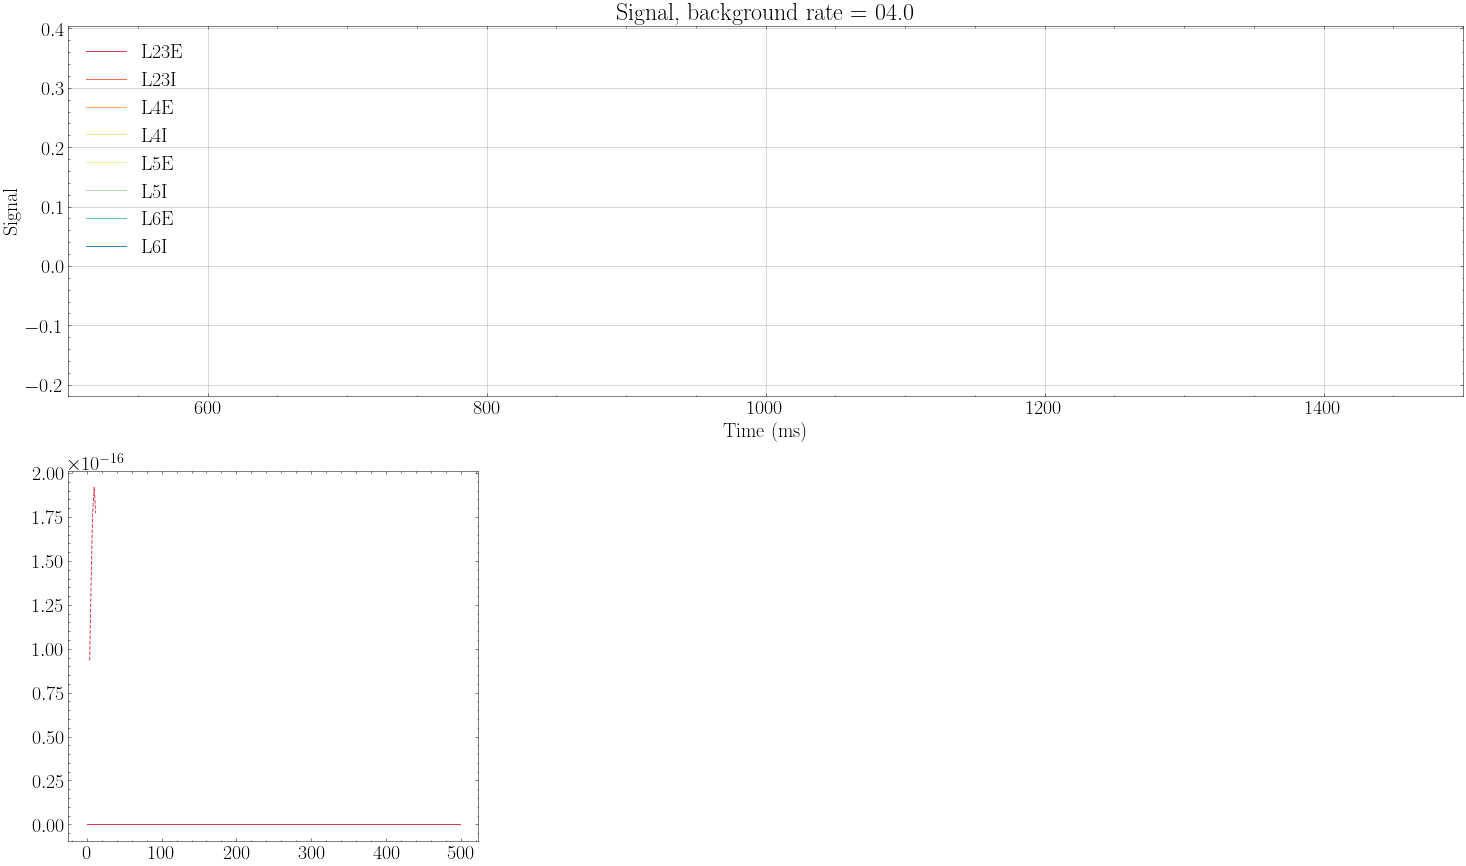

In [16]:
lowcut_alpha = 8
highcut_alpha =12
Fourier_signal_alpha = {}
filtered_signal_alpha = {}
for i in pop_activity:

    name = 'data_background_rate/'+str(i)  +'/results/fft_alpha.dat'
    filtered_signal_alpha[i] = filter_signal(pop_activity[i],lowcut=lowcut_alpha,highcut=highcut_alpha,fs=8000)
    Fourier_signal_alpha[i], FFT_frequencies_alpha, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(filtered_signal_alpha[i],name_=name,rate=i,lim_y=100000,lim_x=100,high_log=100,low_log=0,freq_sample=0.001,freq_sample_welsh=1000,signal_xmax=1500,save=True,fit=True)

/tmp/ipykernel_2164/2785685377.py:63: OptimizeWarning:Covariance of the parameters could not be estimated
/tmp/ipykernel_2164/2785685377.py:85: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_2164/2785685377.py:63: OptimizeWarning:Covariance of the parameters could not be estimated
/tmp/ipykernel_2164/2785685377.py:85: RuntimeWarning:divide by zero encountered in log10
/tmp/ipykernel_2164/2785685377.py:63: OptimizeWarning:Covariance of the parameters could not be estimated


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

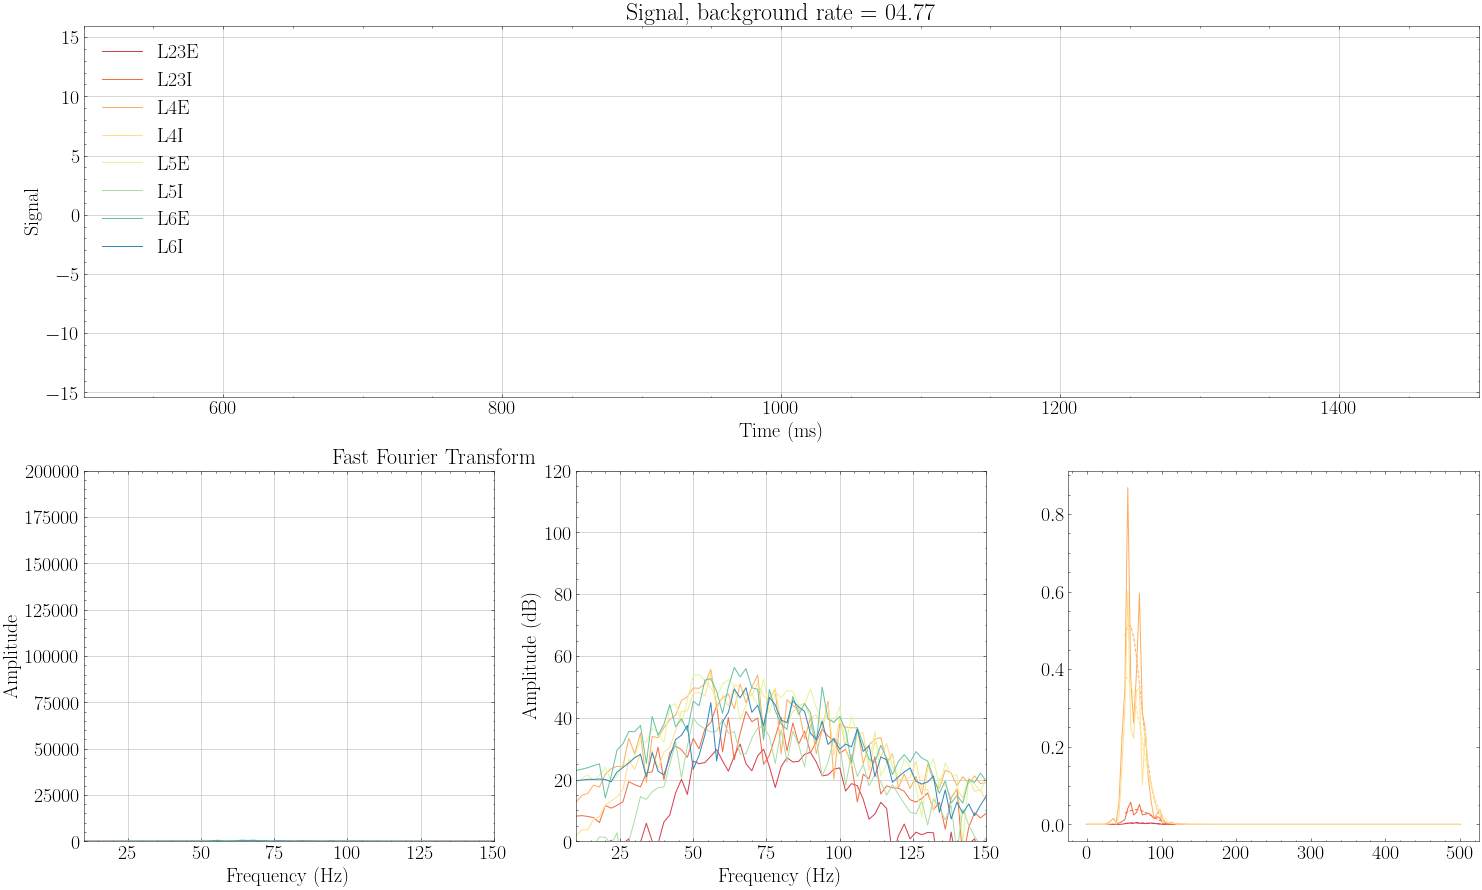

In [17]:
lowcut_gamma = 50
highcut_gamma = 95
Fourier_signal_gamma = {}
filtered_signal_gamma = {}
for i in pop_activity:

    name = 'data_background_rate/'+str(i)  +'/results/fft_gamma.dat'
    filtered_signal_gamma[i] = filter_signal(pop_activity[i],lowcut=lowcut_gamma,highcut=highcut_gamma,fs=1000)
    Fourier_signal_gamma[i], FFT_frequencies_gamma, Welsh_frequencies, Welsh_signal, FFT_index  = compute_FFT(filtered_signal_gamma[i],name_=name,rate=i,lim_y=200000,lim_x=150,high_log=120,low_log=0,freq_sample=0.001,freq_sample_welsh=1000,signal_xmax=1500,save=True,fit=True,welsh_fit='gamma',fit_freq_start=50,fit_freq_end=90,min_x=10)

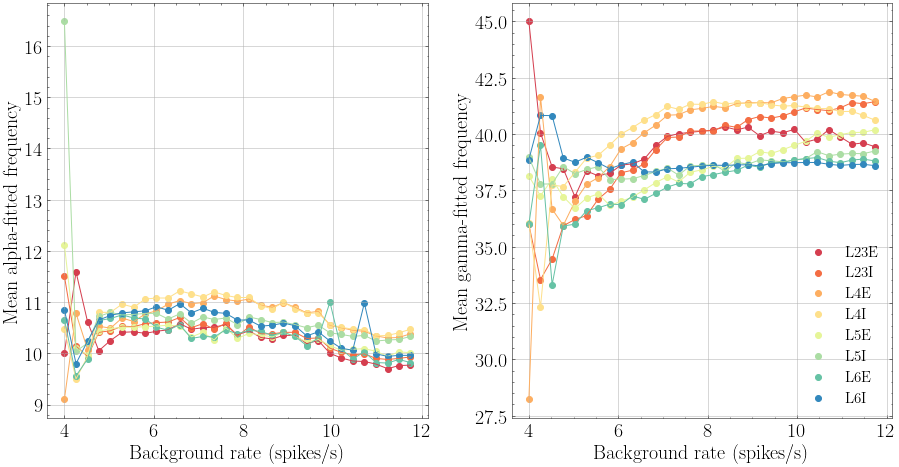

In [18]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams.update({'font.size': 20})


names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']

list_dirs = os.listdir("data_background_rate")
list_dirs = sorted(list_dirs)
del list_dirs[-1]


means_gamma = np.zeros((len(list_dirs),len(names)))
means_alpha = np.zeros((len(list_dirs),len(names)))

std_gamma = np.zeros((len(list_dirs),len(names)))
std_alpha = np.zeros((len(list_dirs),len(names)))

amplitude_gamma = np.zeros((len(list_dirs),len(names)))
amplitude_alpha = np.zeros((len(list_dirs),len(names)))

xlabels = np.zeros(len(list_dirs))

for i in range(len(list_dirs)):
    aid_gamma =  np.loadtxt("data_background_rate/"+list_dirs[i]+"/results/fft_gamma.dat")
    aid_gamma = aid_gamma.transpose()

    means_gamma[i][:] = aid_gamma[1]
    amplitude_gamma[i][:] = aid_gamma[2]
    std_gamma[i][:] = aid_gamma[3]

    aid_alpha =  np.loadtxt("data_background_rate/"+list_dirs[i]+"/results/fft_alpha.dat")
    aid_alpha = aid_alpha.transpose()

    means_alpha[i][:] = aid_alpha[1]
    amplitude_alpha[i][:] = aid_alpha[2]
    std_alpha[i][:] = aid_alpha[3]

    xlabels[i] = float(list_dirs[i])

means_gamma = means_gamma.transpose()
amplitude_gamma = amplitude_gamma.transpose()
std_gamma = std_gamma.transpose()

means_alpha = means_alpha.transpose()
amplitude_alpha = amplitude_alpha.transpose()
std_alpha = std_alpha.transpose()

plt.figure(figsize=(13,7))
plt.subplot(1,2,1)

for i in range(len(means_alpha[:])):
    plt.scatter(xlabels,means_alpha[i][:],label=names[i],color=colours[i])
    plt.plot(xlabels,means_alpha[i][:],color=colours[i])

plt.xlabel('Background rate (spikes/s)')
plt.ylabel("Mean alpha-fitted frequency")
#plt.legend(fontsize=15)
plt.grid()
#plt.ylim(0.5,1.5)
#plt.title("Evolution of synchrony as a function of background rate")

plt.subplot(1,2,2)

for i in range(len(means_gamma[:])):
    plt.scatter(xlabels,means_gamma[i],label=names[i],color=colours[i])
    plt.plot(xlabels,means_gamma[i],color=colours[i])

plt.xlabel('Background rate (spikes/s)')
plt.ylabel("Mean gamma-fitted frequency")
#plt.legend(fontsize=15)
plt.grid()
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [16]:
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

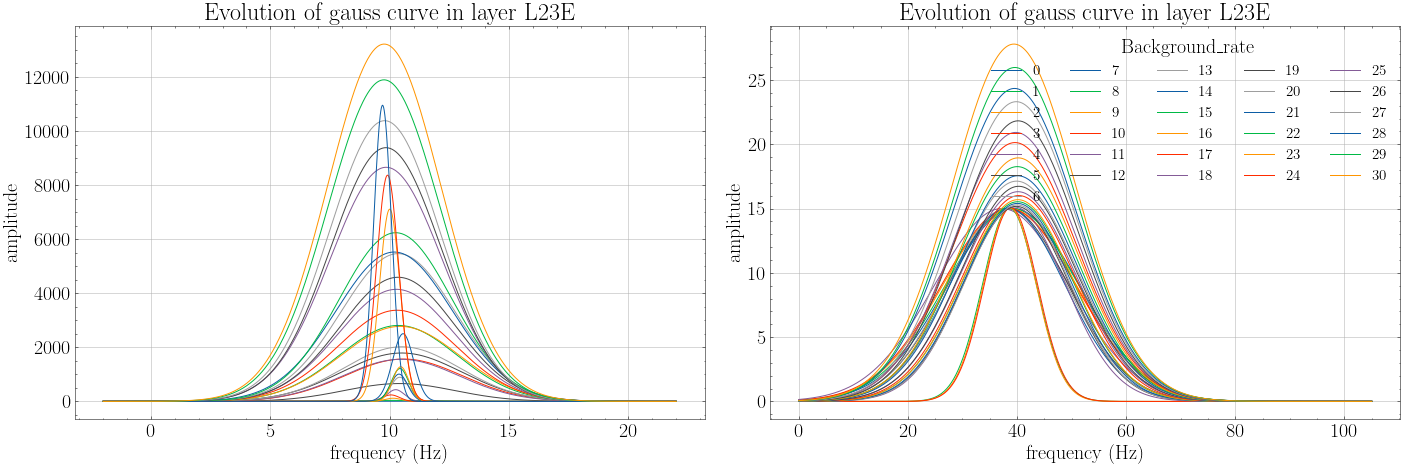

In [17]:
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rcParams.update({'font.size': 20})

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
colours = ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']

list_dirs = os.listdir("data_background_rate")
list_dirs = sorted(list_dirs)


irregularity = {}
lvr = {}

xlabels = np.zeros(len(list_dirs))

layer_of_interest= 0

padding = 10
alpha_points = np.linspace(lowcut_alpha-padding,highcut_alpha+padding,1000)
gamma_points = np.linspace(0,highcut_gamma+padding,1000)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)

means_alpha = means_alpha.transpose()
amplitude_alpha = amplitude_alpha.transpose()
std_alpha = std_alpha.transpose()

for i in range(len(means_alpha[:])):
    plt.plot(alpha_points,gauss(alpha_points,amplitude_alpha[i][layer_of_interest],means_alpha[i][layer_of_interest],std_alpha[i][layer_of_interest]),label=str(i))

plt.xlabel('frequency (Hz)')
plt.ylabel("amplitude")
#plt.legend(fontsize=15,title='Background_rate')
plt.title('Evolution of gauss curve in layer ' + names[layer_of_interest])
plt.grid()


plt.subplot(1,2,2)

means_gamma = means_gamma.transpose()
amplitude_gamma = amplitude_gamma.transpose()
std_gamma = std_gamma.transpose()

for i in range(len(means_gamma)):
    plt.plot(gamma_points,gauss(gamma_points,amplitude_gamma[i][layer_of_interest],means_gamma[i][layer_of_interest],std_gamma[i][layer_of_interest]),label=str(i))

plt.xlabel('frequency (Hz)')
plt.ylabel("amplitude")
plt.legend(fontsize=15,title='Background_rate',ncols=5)
plt.title('Evolution of gauss curve in layer ' + names[layer_of_interest])
plt.grid()
plt.tight_layout()

/tmp/ipykernel_37043/3098560756.py:24: MatplotlibDeprecationWarning:Passing the NFFT parameter of csd() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.


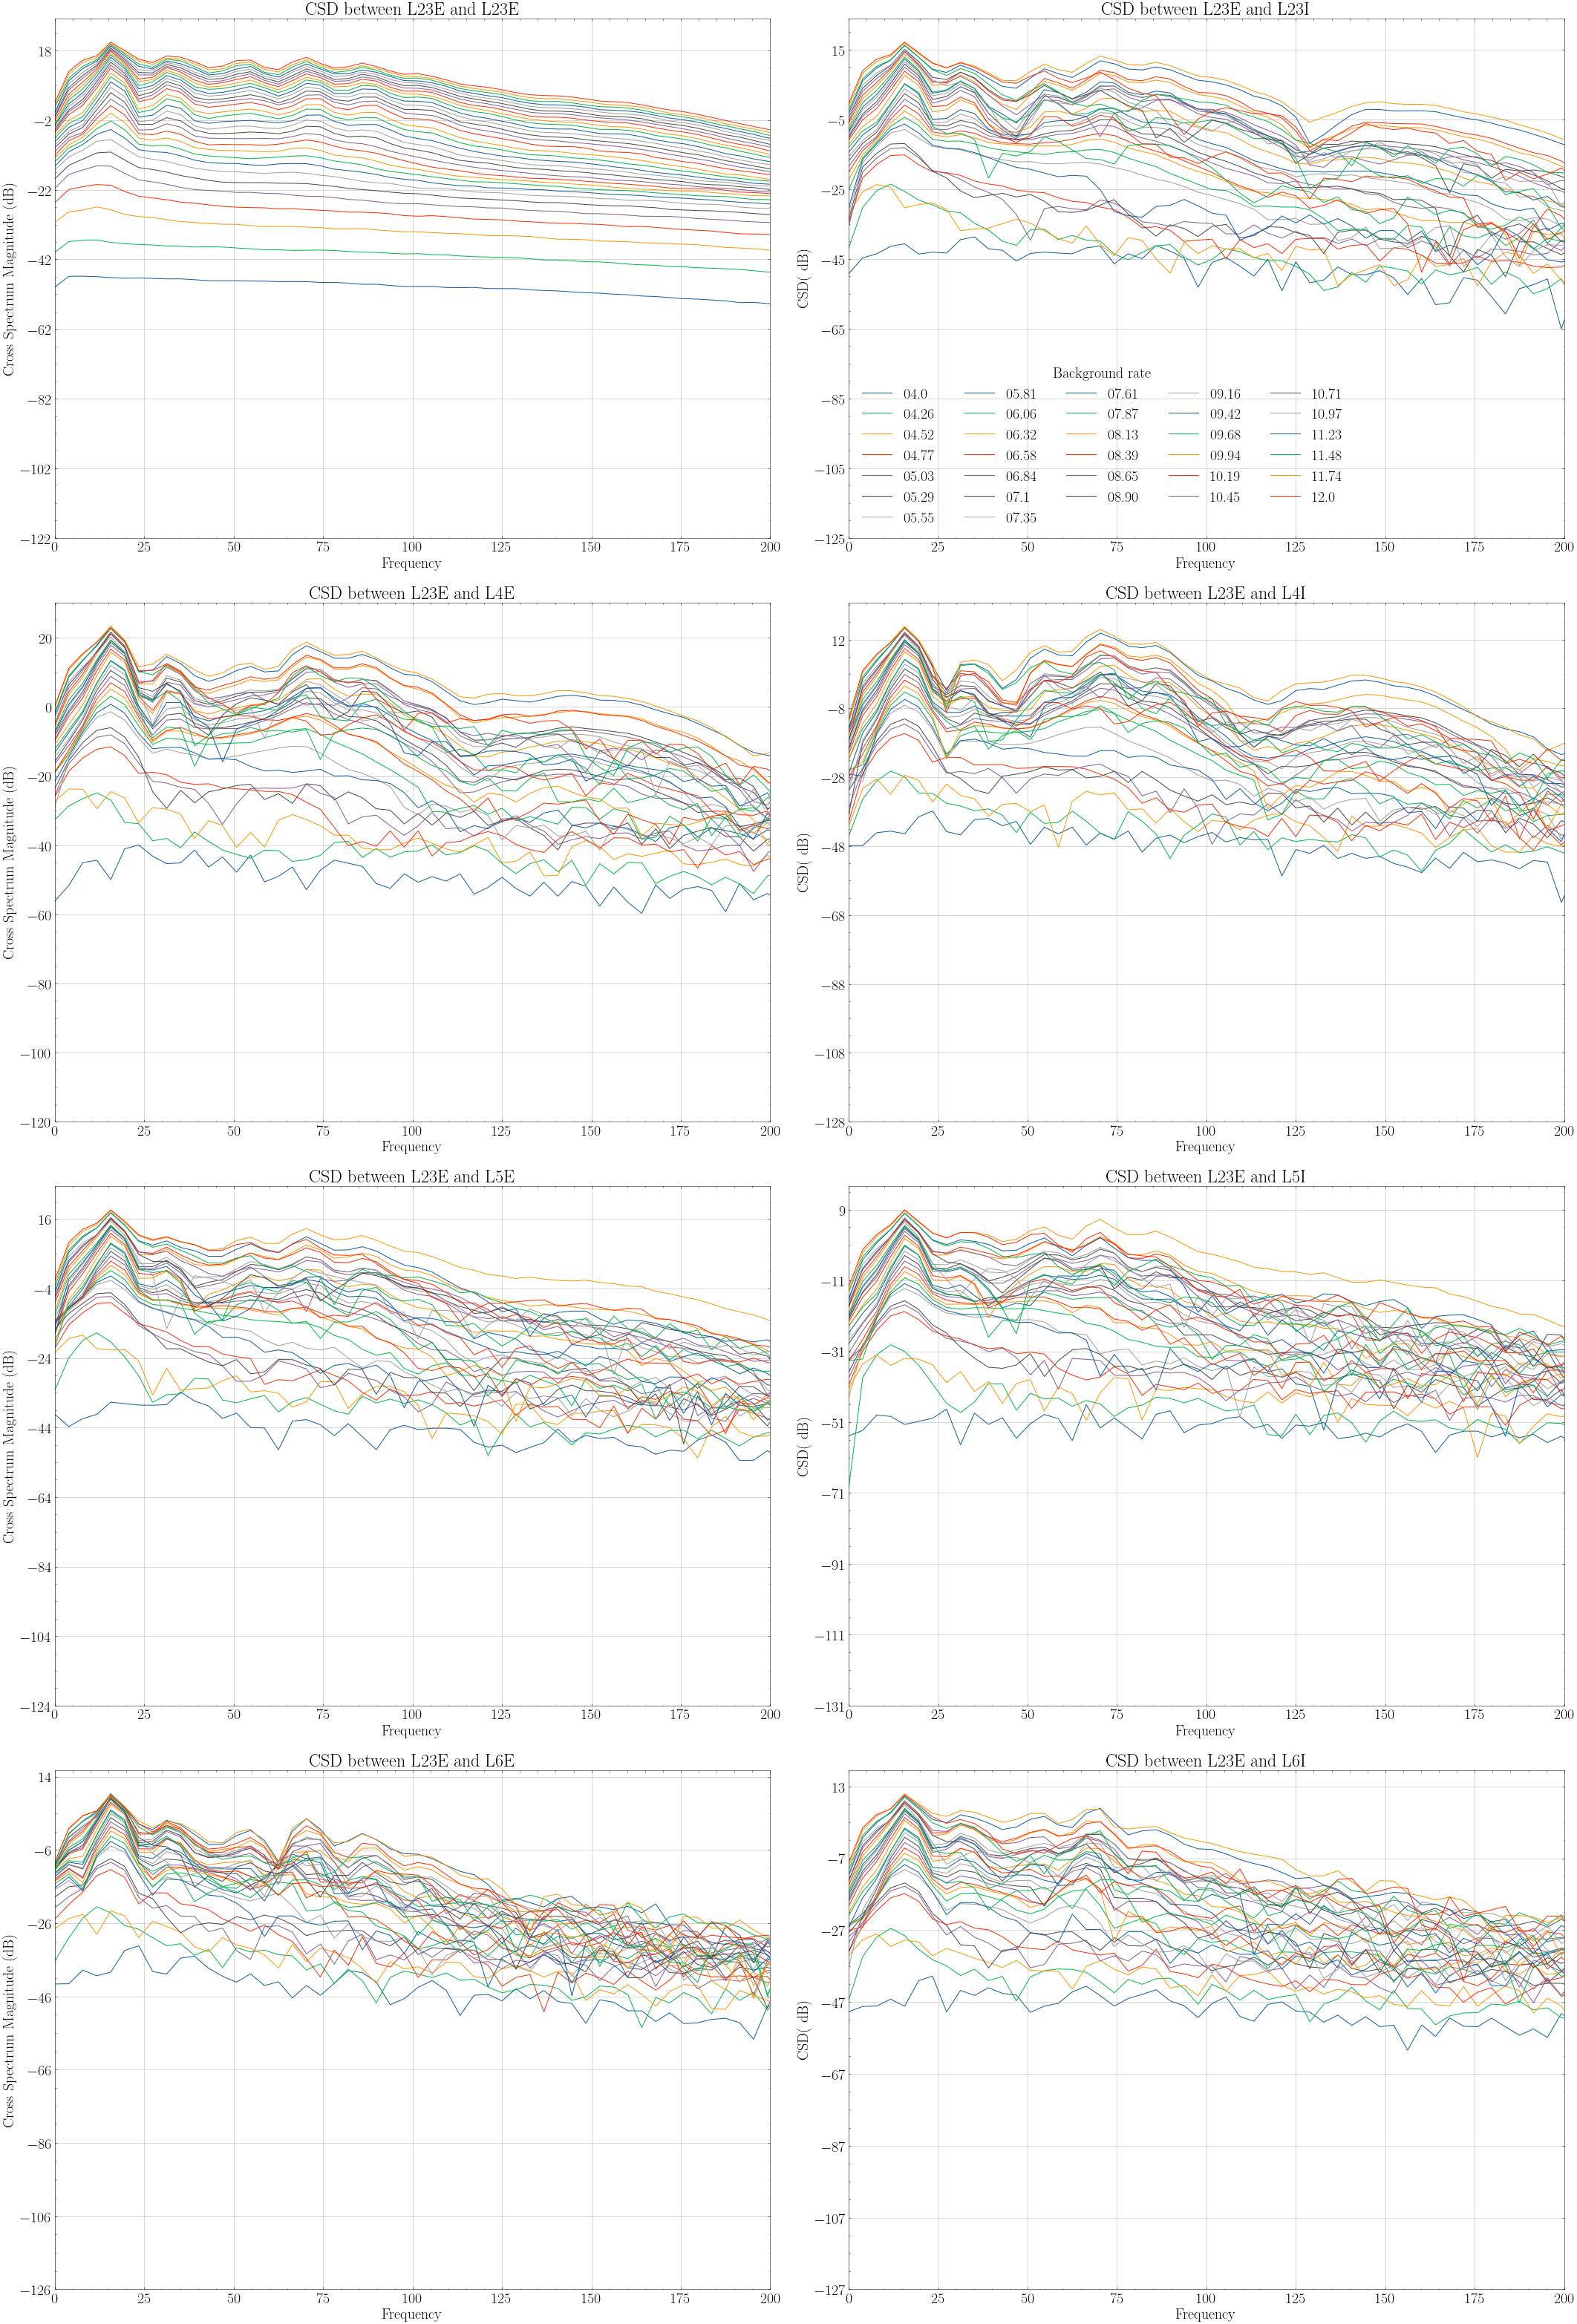

In [18]:
layer_of_interest_og = 0
nfft = 256
dt = 0.001
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]



saved_data_1 = {}
saved_data_2 = {}

for i in pop_activity:
    saved_data_1[i] = pop_activity[i][layer_of_interest_og]

plt.figure(figsize=(30,44))



for j in range(8):
    plt.subplot(4,2,j+1)
    layer_of_interest_2 = j
    for i in pop_activity:
        saved_data_2[i] = pop_activity[i][layer_of_interest_2]
    for i in saved_data_1:
        csdxy, fsc = plt.csd(saved_data_1[i]-np.mean(saved_data_1[i]),saved_data_2[i]-np.mean(saved_data_2[i]),nfft,1./dt,label=str(i))

    if j%2 !=0:
        plt.ylabel('CSD( dB)')
    
    plt.title("CSD between L23E and " +names[j])

    if j == 1:
        plt.legend(title= 'Background rate', ncols= 5)
    plt.xlim(0,200)
#plt.suptitle('Cross spectral density between L23E and the other populations')

plt.tight_layout()

In [20]:
def ComputeBISBIC(S1,S2,FFT_frequencies,Freqs1,Freqs2):
    BIS = np.zeros((len(Freqs1),len(Freqs2)))
    BIC = np.zeros((len(Freqs1),len(Freqs2)))
    for i, f1 in enumerate(Freqs1):
        try:
            ind1 = np.where(FFT_frequencies == f1)[0][0]
        except:
            helper = FFT_frequencies[min(range(len(FFT_frequencies)), key = lambda i: abs(FFT_frequencies[i]-f1))]
            ind1 = np.where(FFT_frequencies == helper)[0][0]

        for j, f2 in enumerate(Freqs2):
            try:
                ind2 = np.where(FFT_frequencies == f2)[0][0]
            except:
                helper = FFT_frequencies[min(range(len(FFT_frequencies)), key = lambda i: abs(FFT_frequencies[i]-f2))]
                ind2 = np.where(FFT_frequencies == helper)[0][0]
            try:
                ind3 = np.where(FFT_frequencies == f1 + f2)[0][0]
            except:
                helper = FFT_frequencies[min(range(len(FFT_frequencies)), key = lambda i: abs(FFT_frequencies[i]-(f2+f1)))]
                ind3 = np.where(FFT_frequencies == helper)[0][0]
            BIS[i,j] = np.abs(np.mean(S1[ind1]*S2[ind2]*np.conj(S2[ind3])))
            BIC[i,j] = BIS[i,j] / ( np.sqrt( np.mean( np.abs(S1[ind1] * S2[ind2])**2 * np.abs(S2[ind3])**2 )   ) )
    return BIS, BIC

            

In [21]:
freqs_alpha = np.linspace(8,12,100)
freqs_gamma_low = np.linspace(30,48,100)
freqs_gamma_high = np.linspace(52,80,100)

layer_of_interest_1 = 0
layer_of_interest_2 = 6

BIS = {}
BIC = {}

for i, n in enumerate(Fourier_signal_alpha):

    BIS[i], BIC[i] = ComputeBISBIC(Fourier_signal_alpha[n][layer_of_interest_1],Fourier_signal_alpha[n][layer_of_interest_2],FFT_frequencies_alpha,freqs_alpha,freqs_gamma_low)

/tmp/ipykernel_37043/531843700.py:3: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


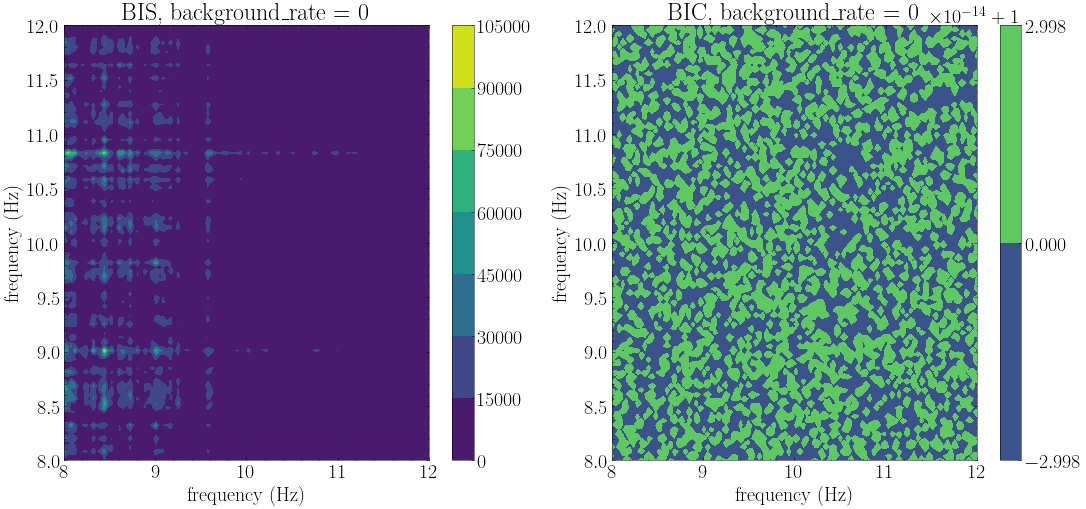

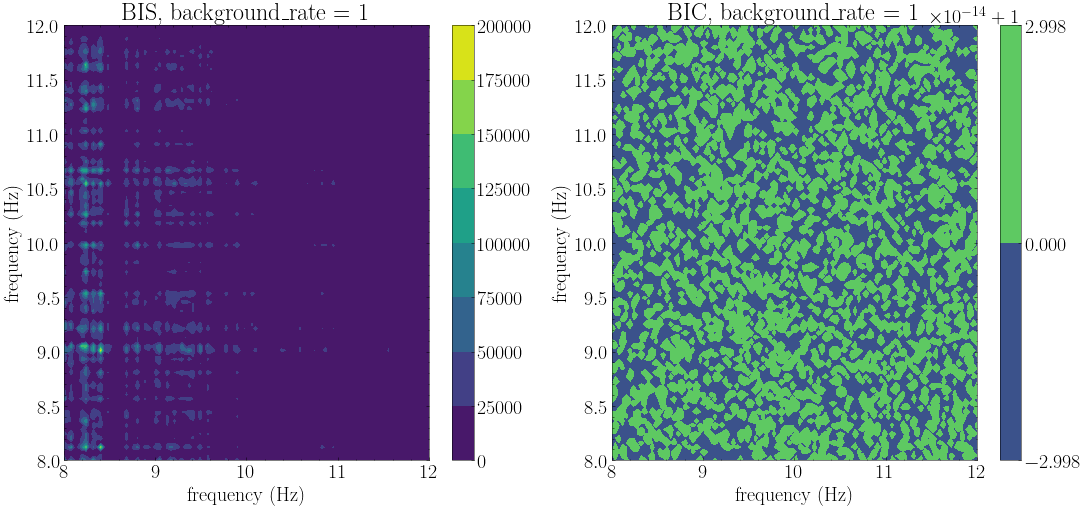

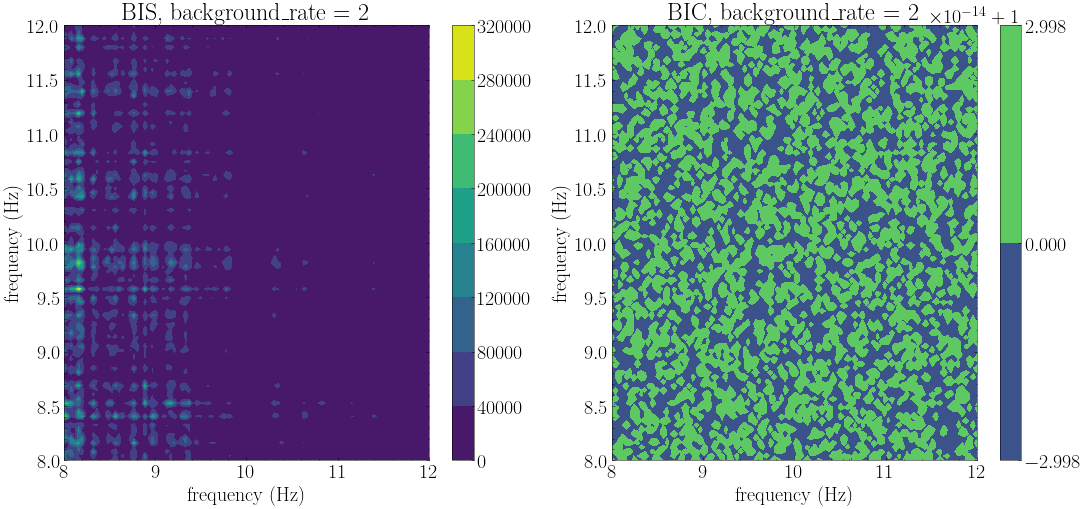

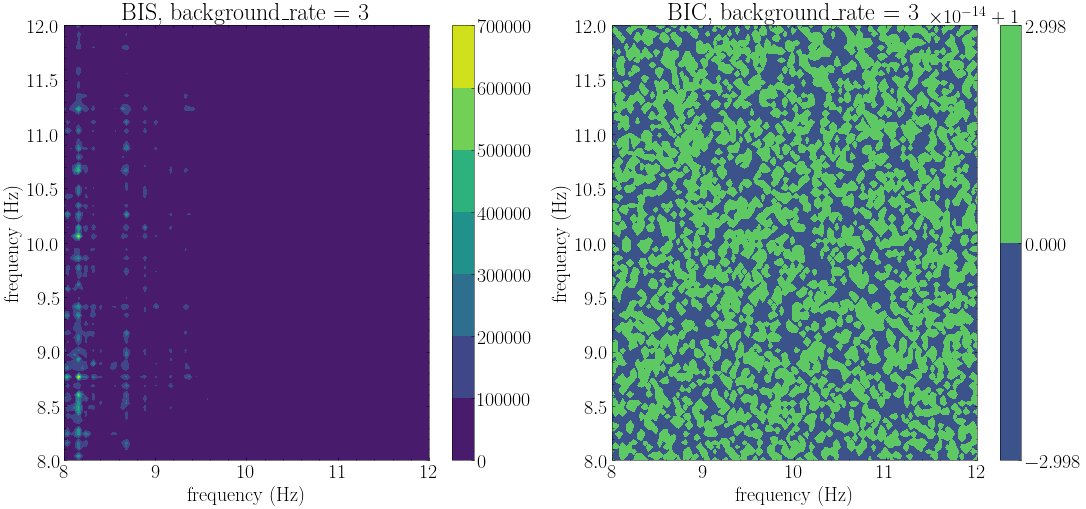

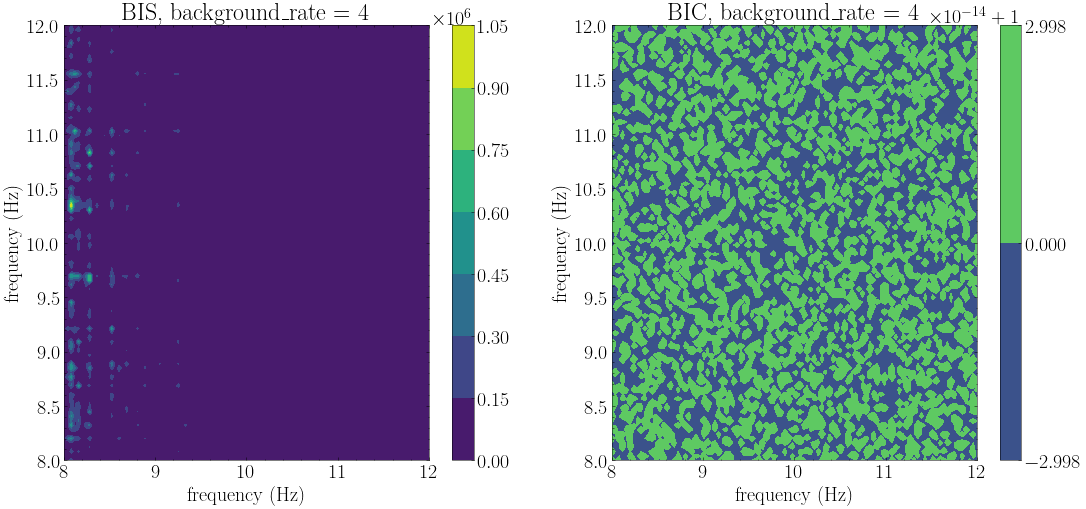

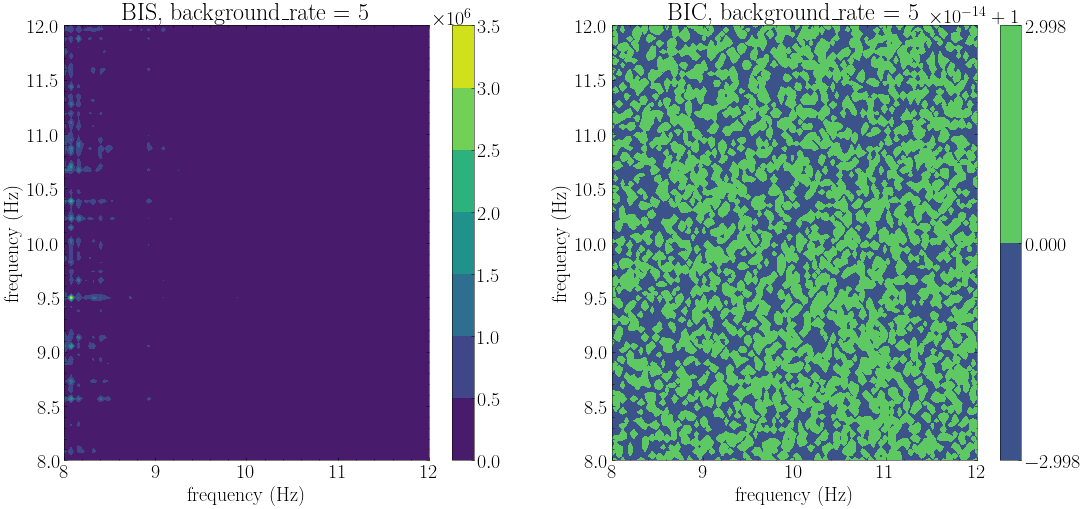

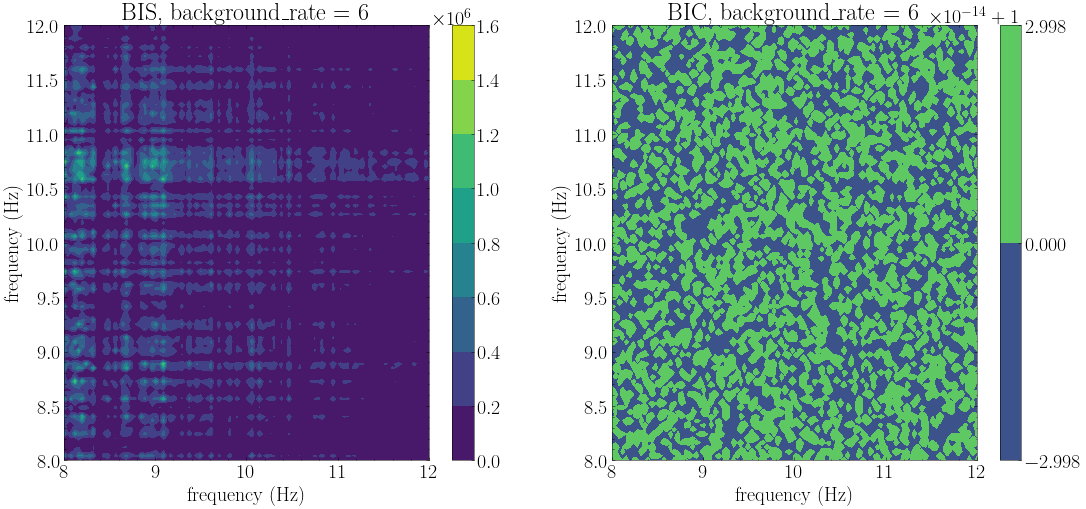

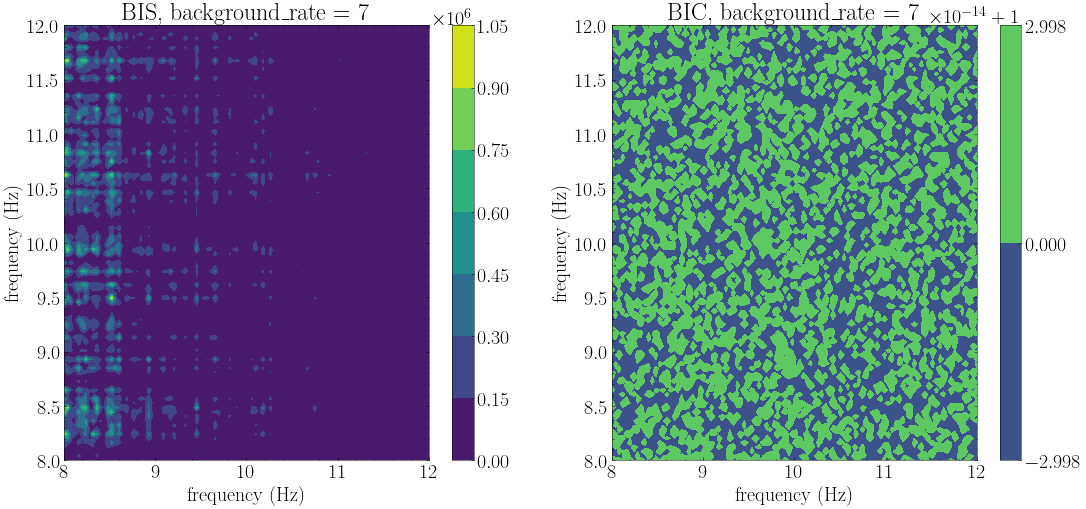

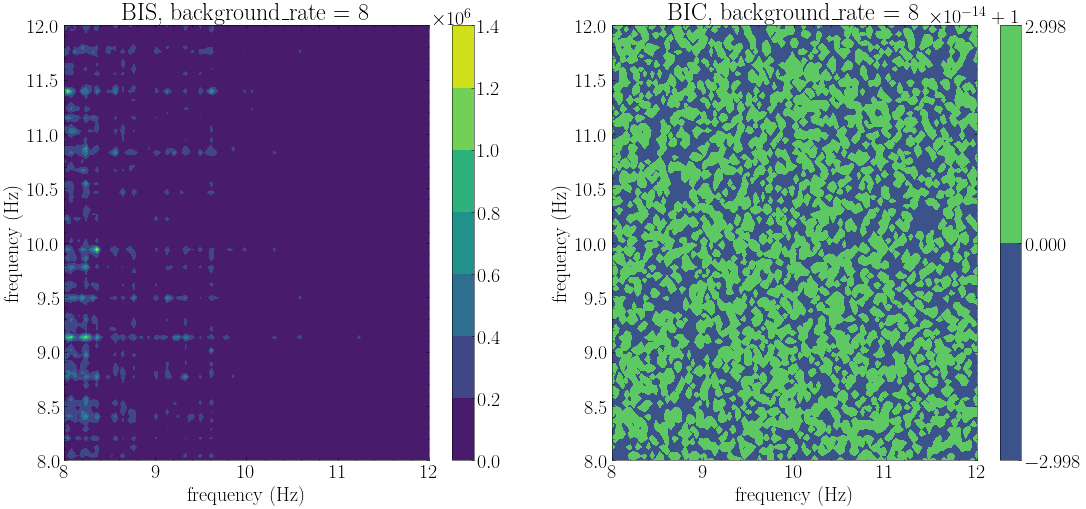

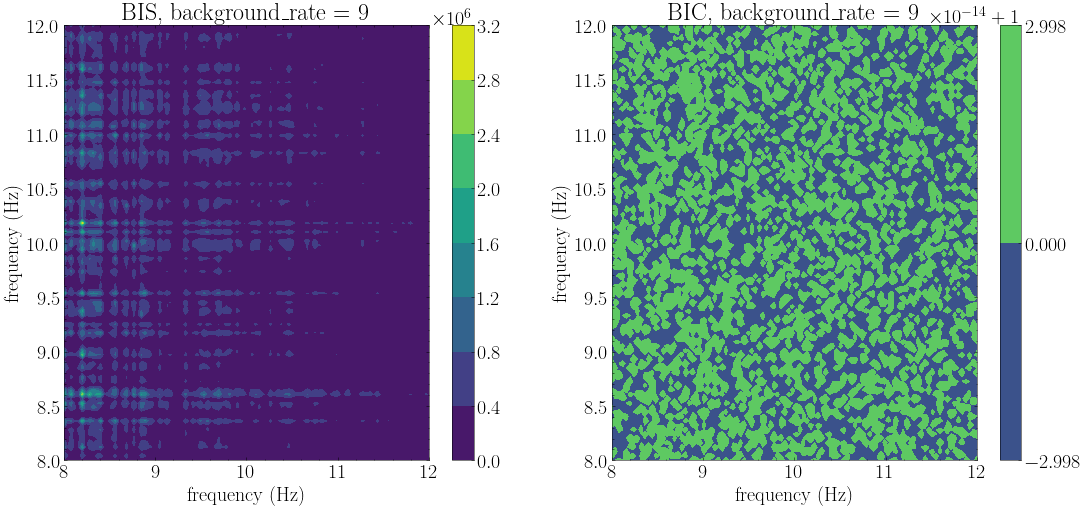

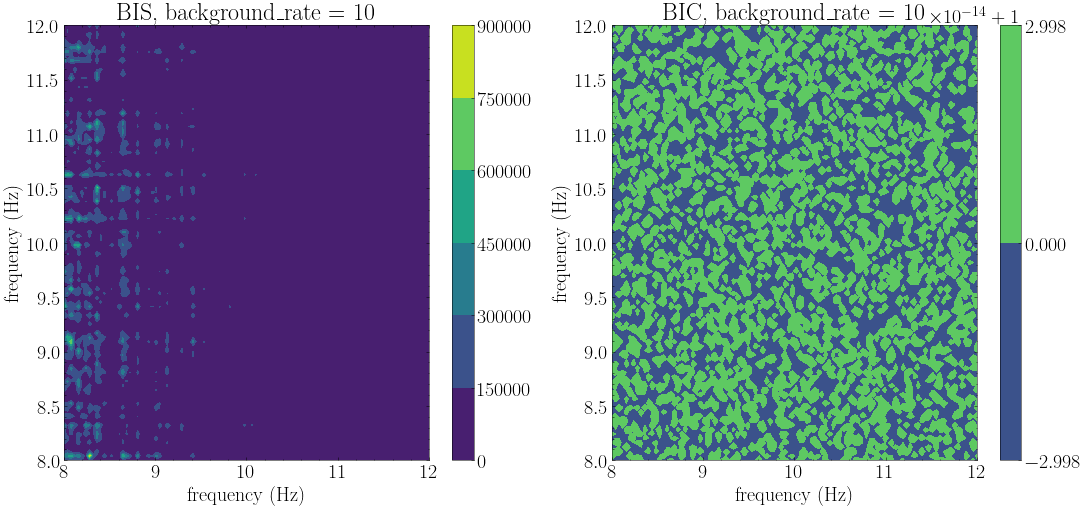

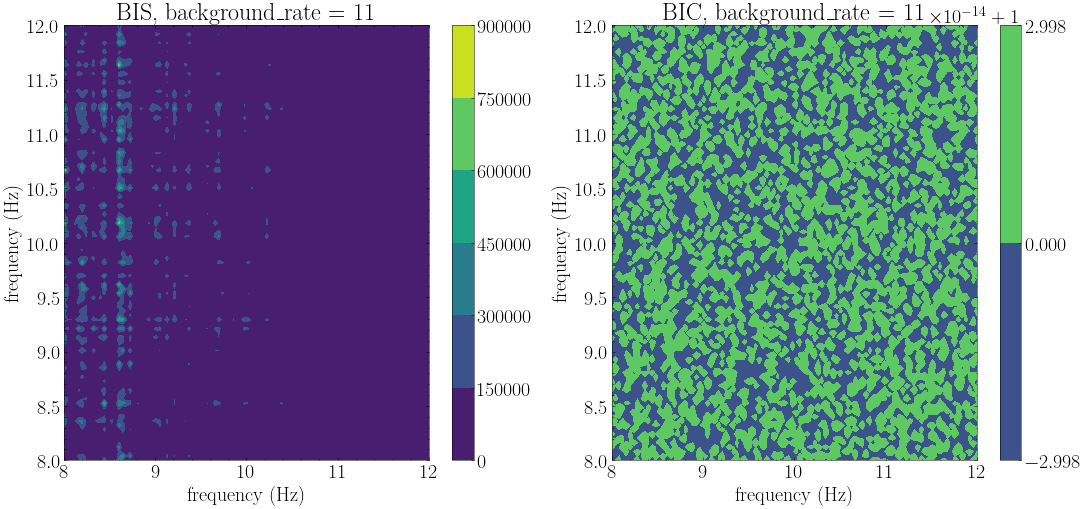

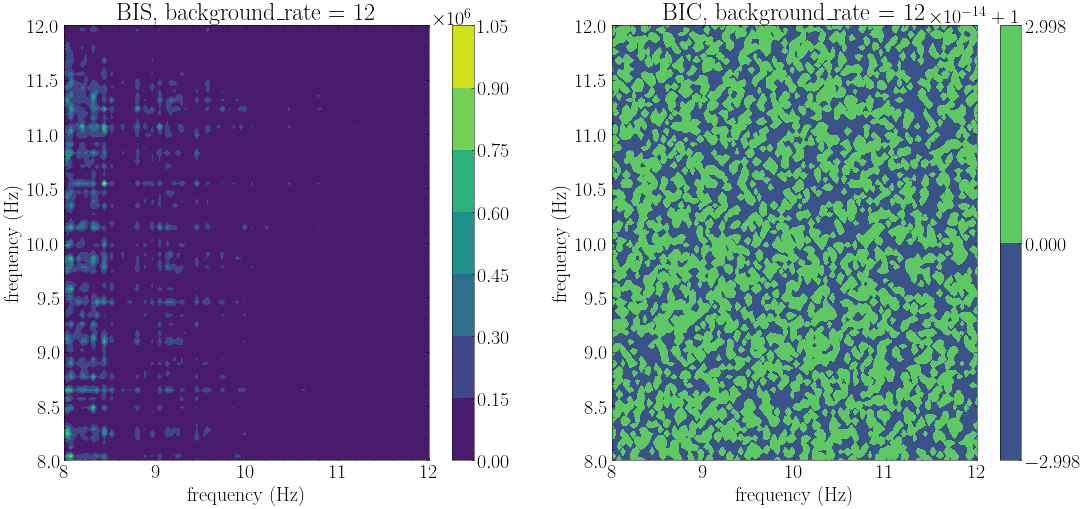

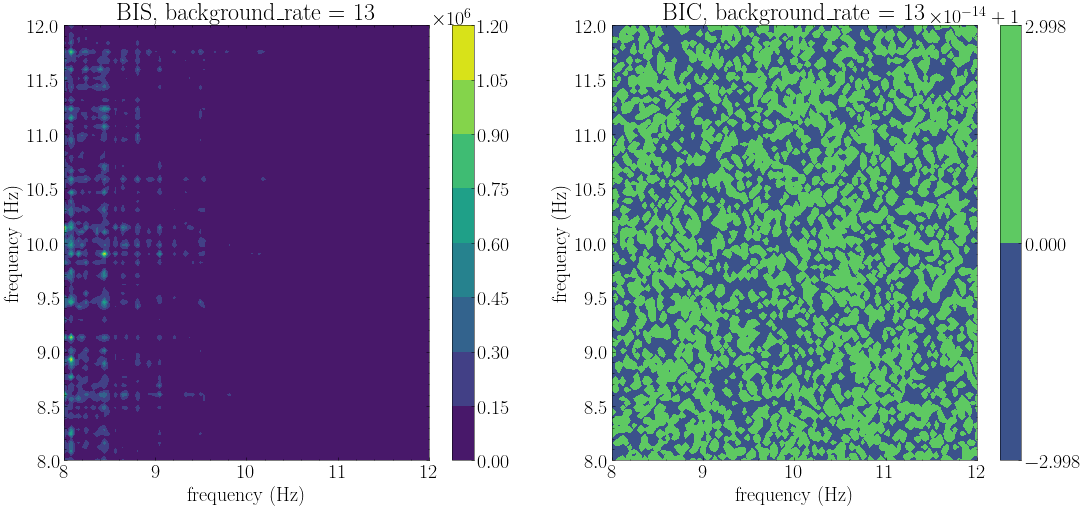

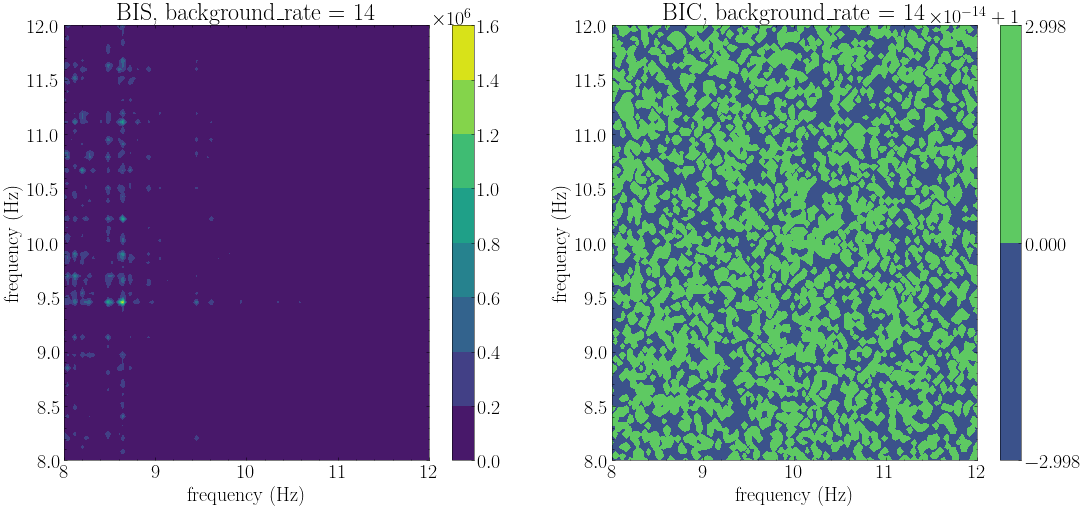

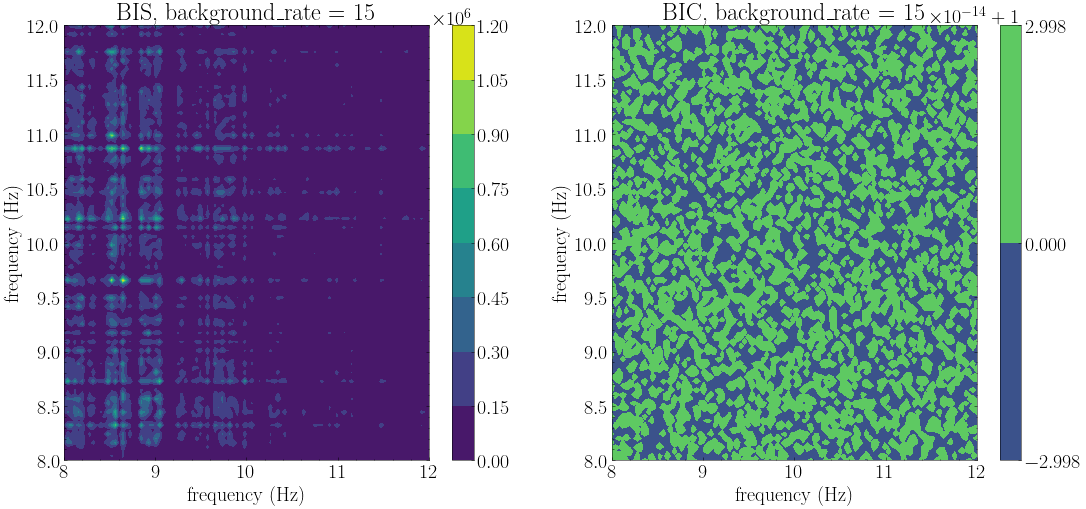

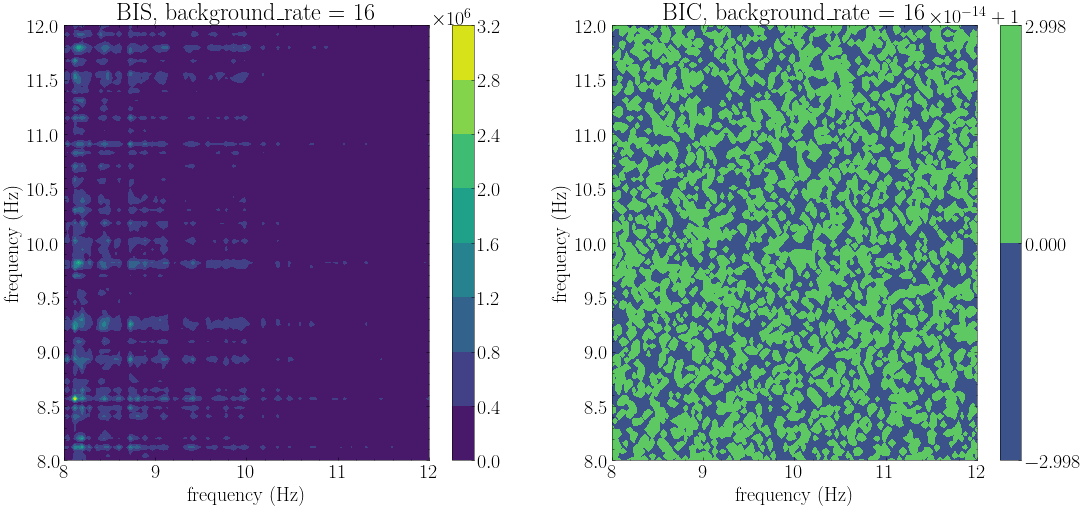

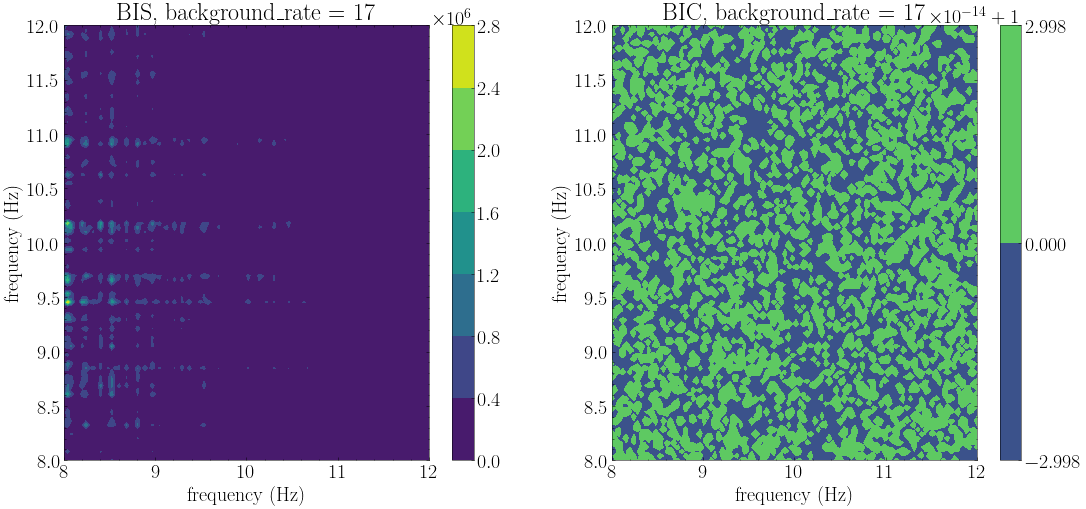

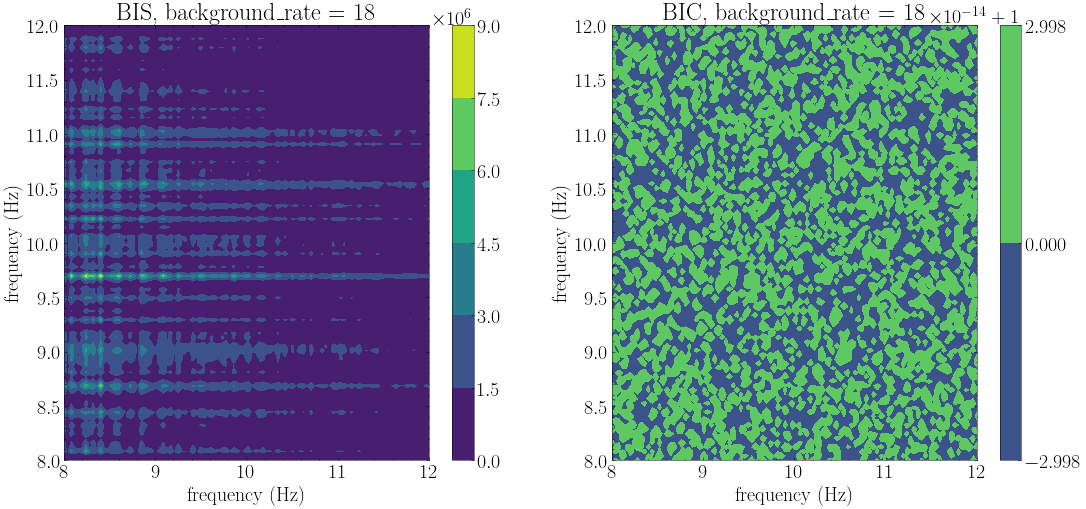

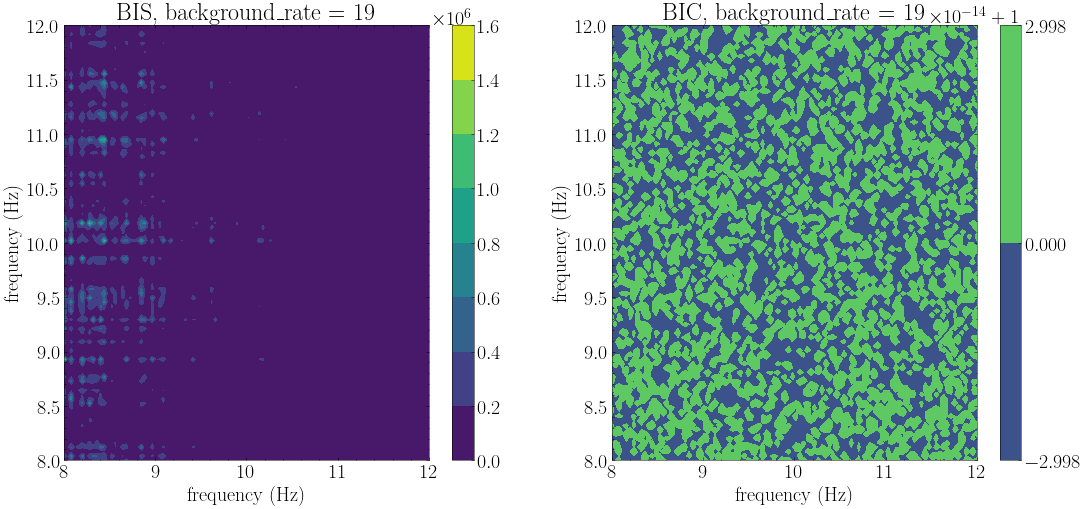

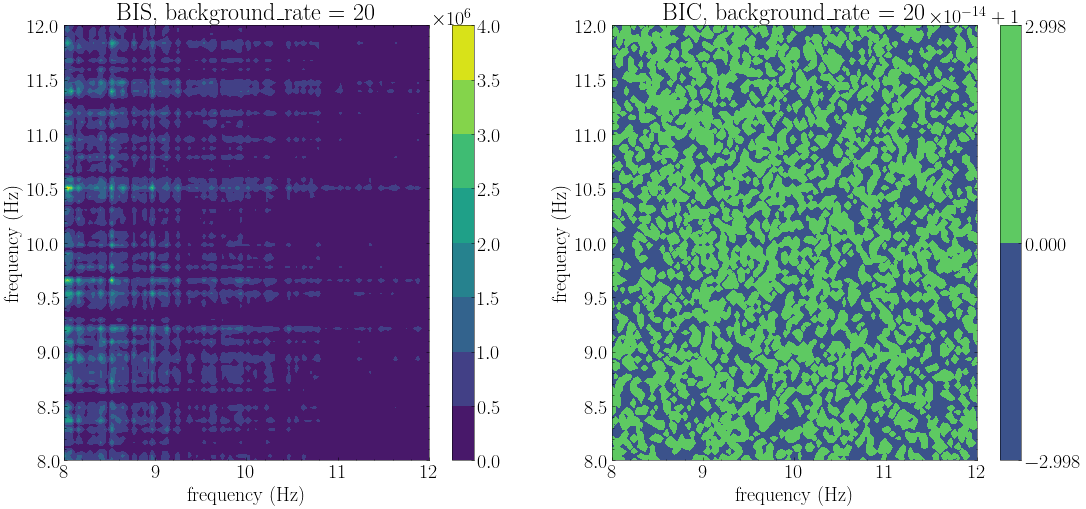

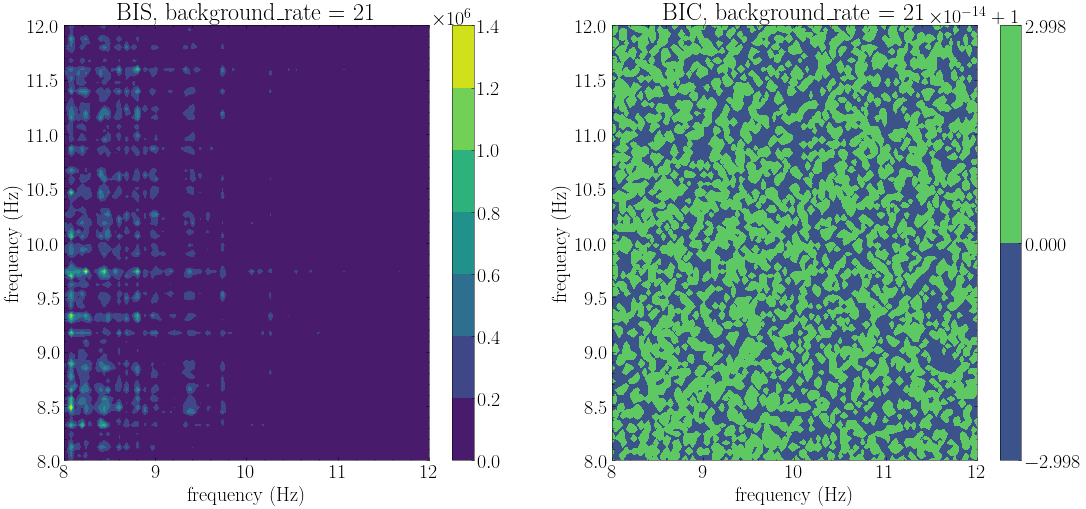

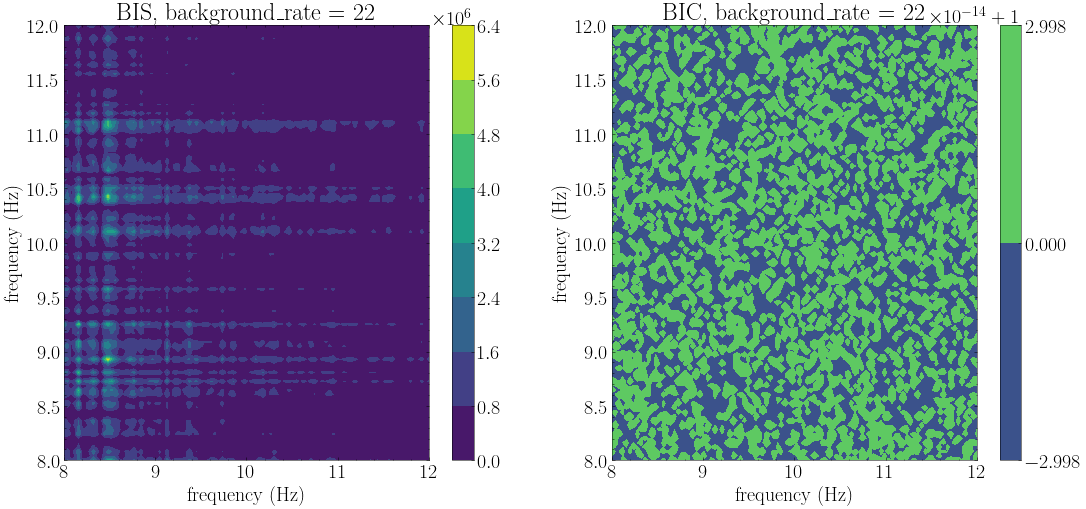

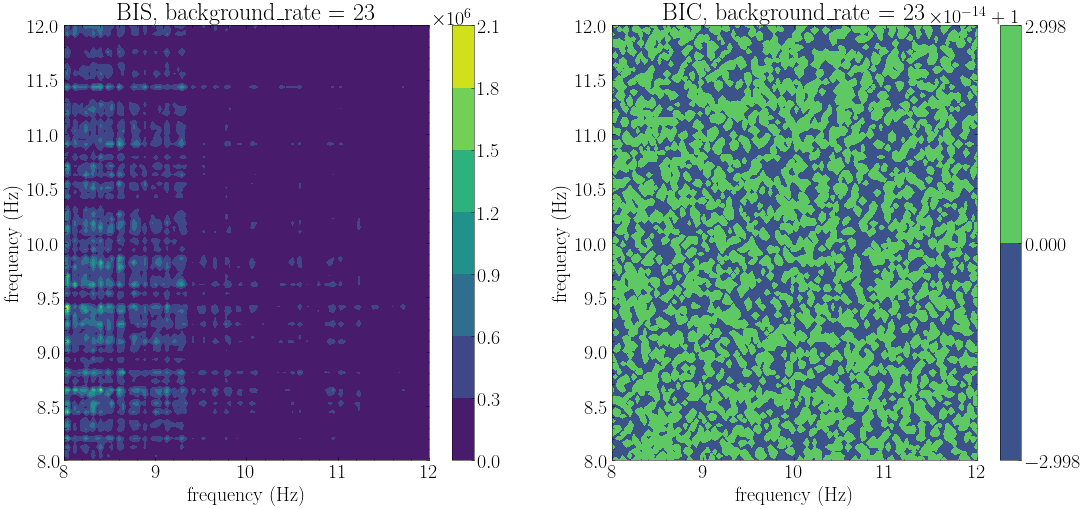

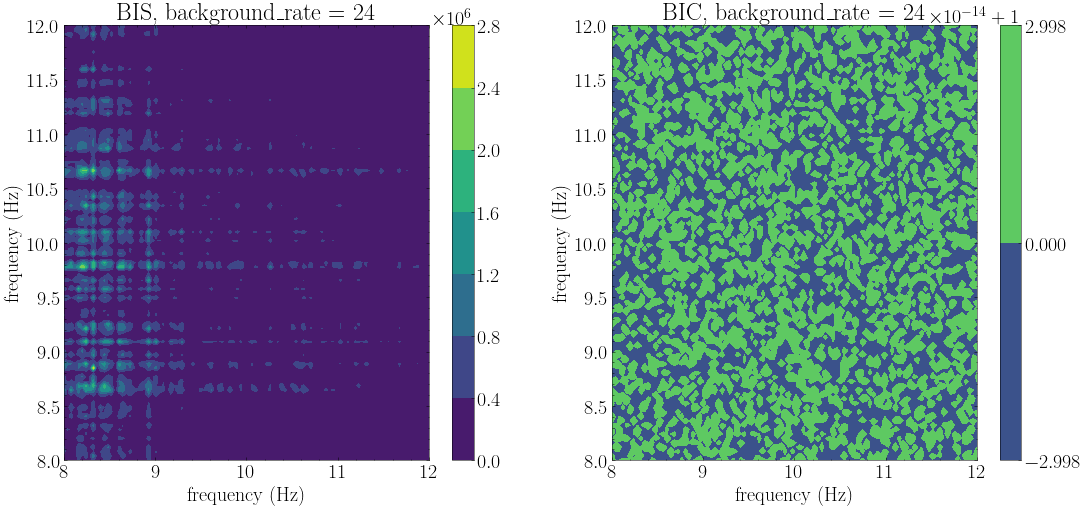

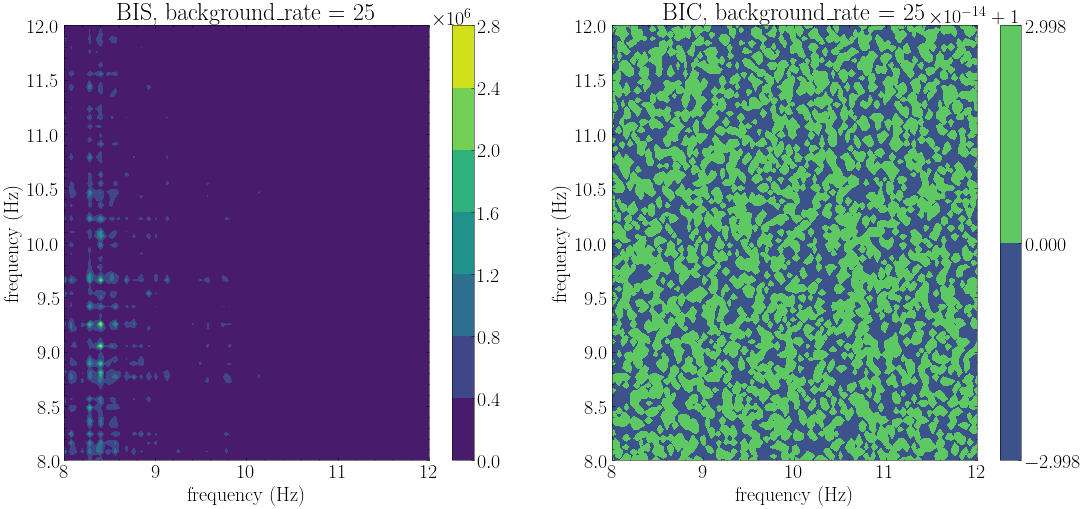

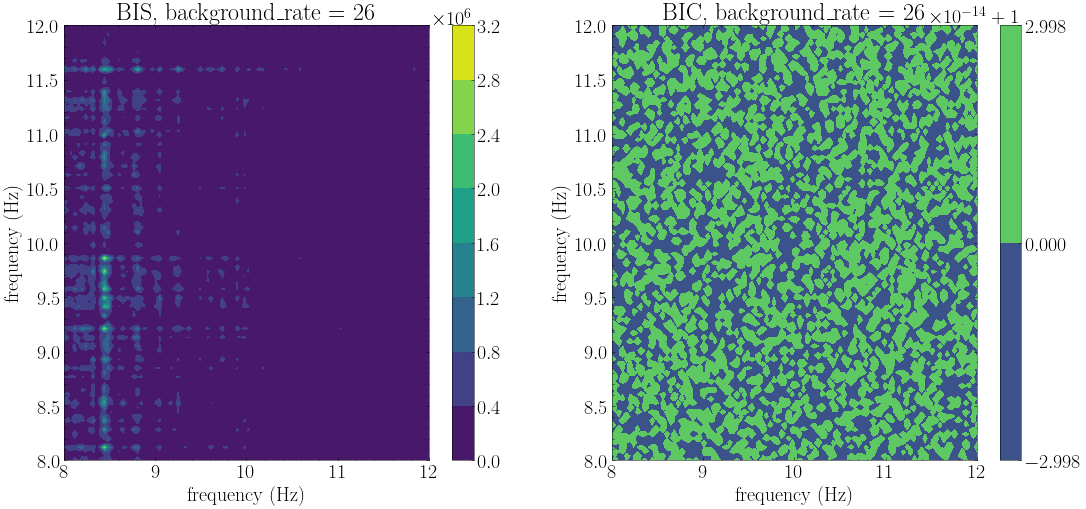

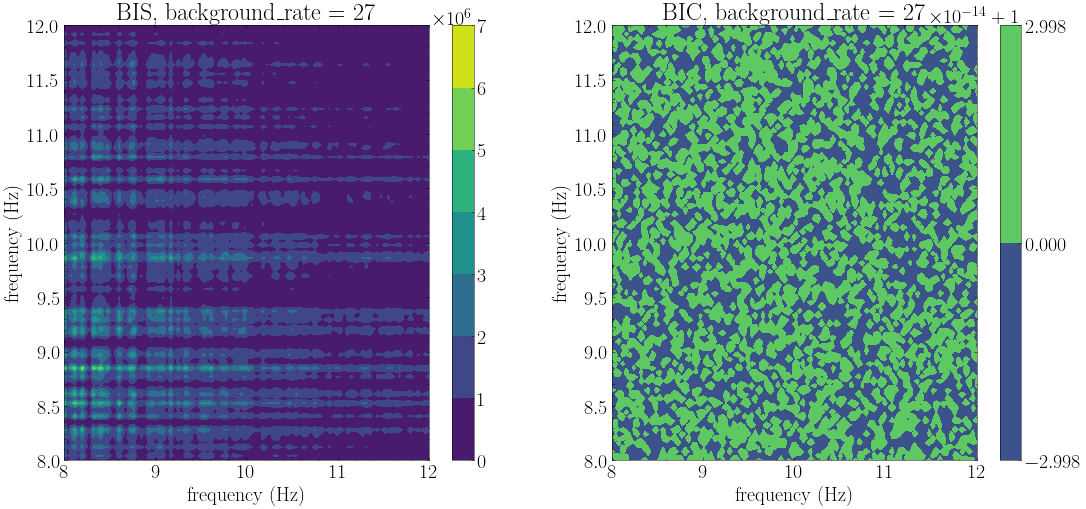

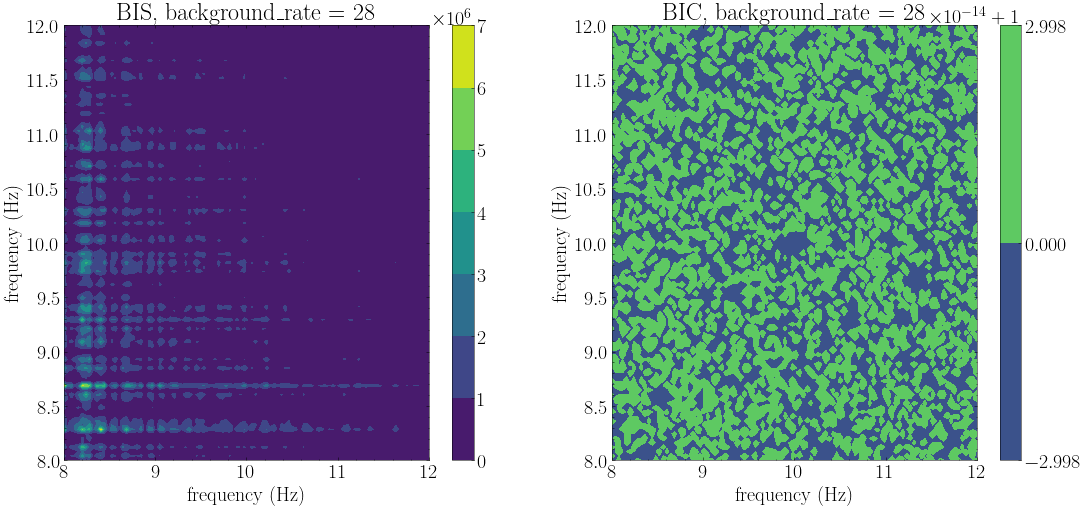

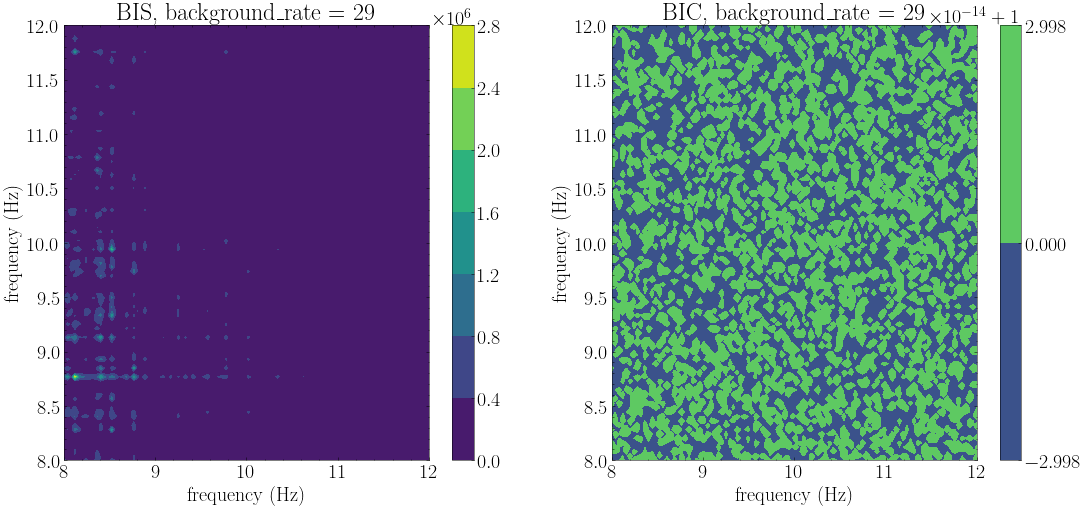

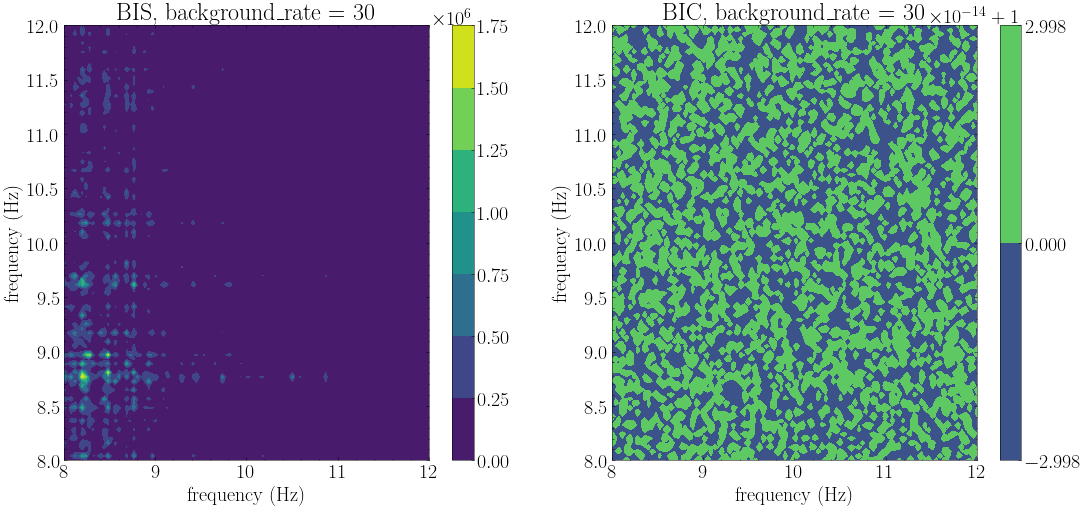

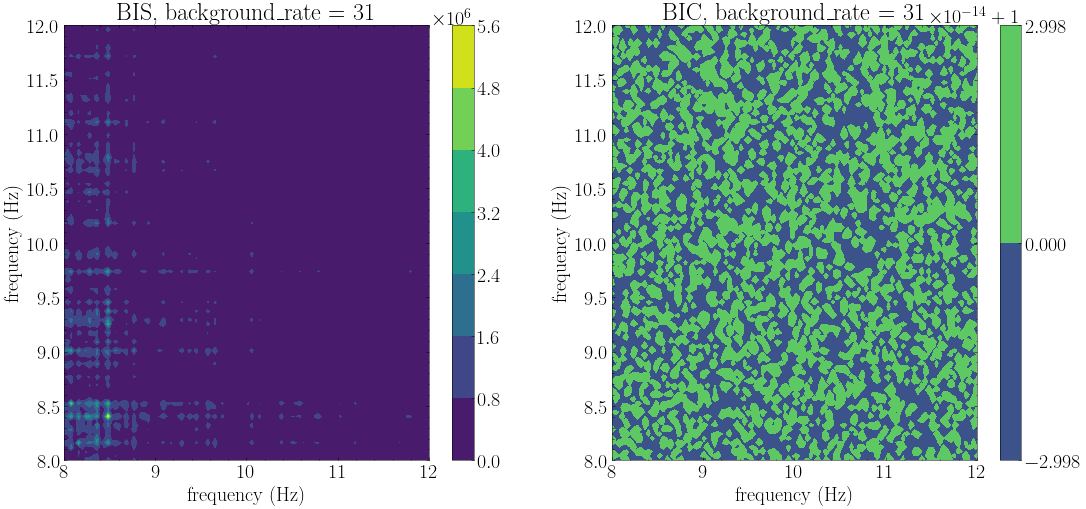

In [22]:
for i in range(len(BIS)):

    plt.figure(figsize=(18,8))
    plt.subplot(1,2,1)

    plt.contourf(freqs_alpha,freqs_alpha,BIS[i])
    plt.xlabel('frequency (Hz)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()
    plt.title('BIS, background_rate = ' + str(i))

    plt.subplot(1,2,2)

    plt.contourf(freqs_alpha,freqs_alpha,BIC[i])
    plt.xlabel('frequency (Hz)')
    plt.ylabel('frequency (Hz)')
    plt.colorbar()
    plt.title('BIC, background_rate = ' + str(i))

In [ ]:
base_layer = 0

CFC_s = {}
frequencies_base = {}
frequencies_2 = {}

signal_hilbert = {}

filter_low = 0
filter_high = 88

for i, n in enumerate(pop_activity):
    CFC_s[i] = {}
    frequencies_base[i] = {}
    frequencies_2[i] = {}
    for j, m in enumerate(pop_activity[n]):
        signal_hilbert[base_layer] = hilbert_transform(pop_activity[n][base_layer])
        if j != base_layer:
            signal_hilbert[j] = hilbert_transform(pop_activity[n][j])
            help = np.fft.fft(signal_hilbert[base_layer])
            W = np.fft.fftfreq(len(signal_hilbert[base_layer]),d=0.001)
            help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

            signal_base = np.fft.ifft(help)

            help = np.fft.fft(signal_hilbert[j])
            W = np.fft.fftfreq(len(signal_hilbert[j]),d=0.001)
            help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

            signal_2 = np.fft.ifft(help)

            z = signal_base * np.conjugate(signal_2) / (np.abs(signal_base) * np.abs(signal_2))
            welsh_power = np.abs(np.fft.fft(z-np.mean(z)))
            welsh_frequencies = np.fft.fftfreq(len(z),d=0.001)

            maximum = np.max(welsh_power)
            padding = 1
            distance = np.abs(welsh_frequencies[0] - welsh_frequencies[1])

            point = np.argwhere(welsh_power==maximum)[0][0] 

            central_freq = welsh_frequencies[point]
            start = point-int(padding/distance)

            stop = point+int(padding/distance)
            if stop > len(welsh_frequencies):
                stop = len(welsh_frequencies) -1

            num = int((-start +stop)/distance)
            base_point_list = np.linspace(start,stop,num)
            base_point_list = base_point_list.astype(int)

            if central_freq + padding > 0 and central_freq < 0:
                support_freqs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
                base_point_list = np.append(base_point_list,support_freqs)
                freqs_plots = welsh_frequencies[base_point_list]
                power_plot = welsh_power[base_point_list]
            elif central_freq - padding < 0  and central_freq >0 :
                help = np.argwhere(welsh_frequencies<0)[0][0]
                support_freqs = [help,help+1,help+2,help+3,help+4,help+5,help+6,help+7,help+8,help+9,help+10,help+11,help+12,help+13,help+14,help+15,help+16,help+17,help+18,help+19]
                base_point_list = np.append(base_point_list,support_freqs)
                freqs_plots = welsh_frequencies[base_point_list]
                power_plot = welsh_power[base_point_list]
            else:
                freqs_plots = welsh_frequencies[base_point_list]
                power_plot = welsh_power[base_point_list]


            int_num = np.trapz(power_plot,x=freqs_plots)
            int_dem = np.trapz(welsh_power,x=welsh_frequencies)
            CFC_s[i][j] = int_num / int_dem

            frequencies = np.linspace(0,88,num=100)
            sigma = 1
            for l in frequencies:
                lowcut = l - sigma
                highcut = l + sigma
                help = np.fft.fft(signal_base)
                W = np.fft.fftfreq(len(signal_base),d=0.001)
                help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

                filtered_signal = np.fft.ifft(help)


                test_z = filtered_signal * np.conjugate(signal_2) / (np.abs(filtered_signal) * np.abs(signal_2))

                welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
                welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

                maximum_new = np.max(welsh_power)
                point = np.argwhere(welsh_power==maximum_new)[0][0] 
                central_freq_new = welsh_frequencies[point]
                if maximum_new < maximum/1.2:
                    frequencies_base[i][j] = l 
                    break 

            for l in frequencies:
                lowcut = l - sigma
                highcut = l + sigma
                help = np.fft.fft(signal_2)
                W = np.fft.fftfreq(len(signal_2),d=0.001)
                help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

                filtered_signal = np.fft.ifft(help)


                test_z = signal_base * np.conjugate(filtered_signal) / (np.abs(filtered_signal) * np.abs(signal_base))

                welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
                welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

                maximum_new = np.max(welsh_power)
                point = np.argwhere(welsh_power==maximum_new)[0][0] 
                central_freq_new = welsh_frequencies[point]
                if maximum_new < maximum/1.3:
                    frequencies_2[i][j] = l 
                    break 
            

NameError: name 'pop_activity' is not defined

In [22]:
populations = ['L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']

CFC = np.zeros((len(CFC_s),len(CFC_s[0])))
for i in range(len(CFC_s)):
    CFC[i] = np.fromiter(CFC_s[i].values(),dtype=float)
bg_rate = np.linspace(4,12,int((12-4)/0.25))

Text(0, 0.5, 'CFC-PLM')

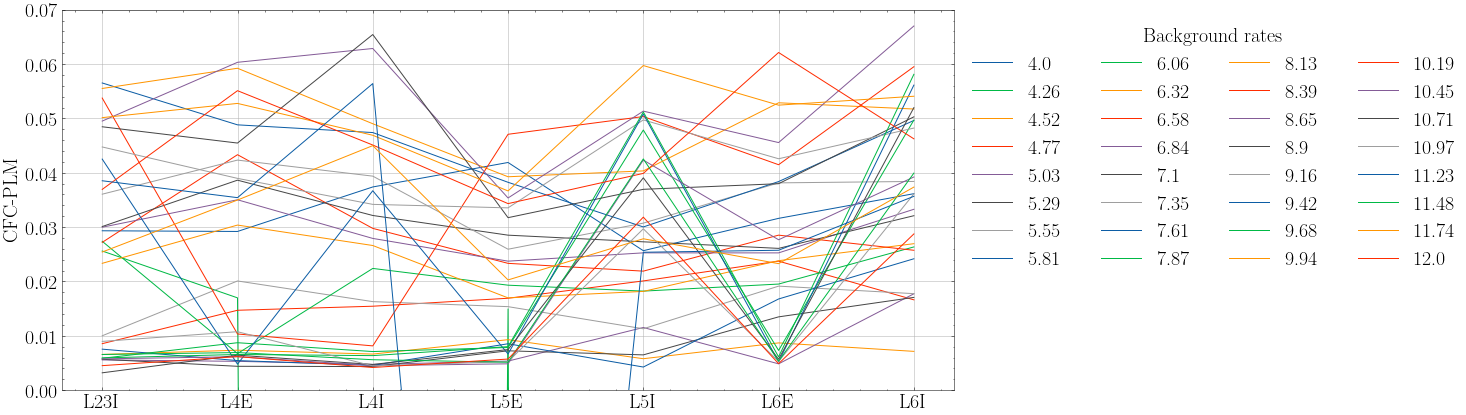

In [23]:
plt.figure(figsize=(16,7))
y_pos = 1.0


for i in range(len(CFC_s)):
    plt.plot(populations,CFC[i], label = round(bg_rate[i],2) )

plt.legend(ncols = 4,bbox_to_anchor=(1.0,1.0),title='Background rates')
plt.ylim(0,0.07)
plt.grid()
plt.ylabel('CFC-PLM')

In [24]:
frequencies_base[10]

{1: 16.0, 2: 16.0, 3: 16.0, 5: 16.0, 6: 16.0, 7: 16.0}

In [25]:
frequencies_2[10]

{5: 0.0, 6: 0.0, 7: 0.0}

In [31]:
len(means_gamma.transpose())

31

In [58]:

index =16 

means_gamma  = means_gamma.transpose()
means_alpha = means_alpha.transpose()


#periods_gamma = 1 / means_gamma[16] * 1000
#periods_alpha = 1 / means_alpha[16] * 1000

periods_gamma = 1 / means_gamma[16] * 1000
periods_alpha = 1 / means_alpha[16] * 1000

mean_period_gamma = np.mean(periods_gamma)
mean_period_alpha = np.mean(periods_alpha)

raster_plot_interval = np.array([500, 500 + 3* mean_period_alpha])

In [104]:
def plot_raster(path, name, begin, end, N_scaling,binned,M, std,period_alpha,period_gamma,period_volt):
    """Creates a spike raster plot of the network activity.

    Parameters
    -----------
    path
        Path where the spike times are stored.
    name
        Name of the spike recorder.
    begin
        Time point (in ms) to start plotting spikes (included).
    end
        Time point (in ms) to stop plotting spikes (included).
    N_scaling
        Scaling factor for number of neurons.

    Returns
    -------
    None

    """
    from scipy import signal
    fs = 18  # fontsize
    ylabels = ["L2/3E", "L2/3I", "L4E", "L4I", "L5E", "L5I", "L6E","L6I"]
    color_list = ['#d6949c', '#f5b7a4', '#fcd4ac', '#ffeebf', '#edf5c9', '#d2ded1', '#b4c2be', '#7da4bd']
    bar_labels =  ['#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
    
    sd_names, node_ids, data = helpers.__load_spike_times(path, name, begin, end)
    last_node_id = node_ids[-1, -1]
    mod_node_ids = np.abs(node_ids - last_node_id) + 1
    label_pos = np.zeros(8)

    for i in np.arange(0,8,1):
        if i%2 == 0:
            label_pos[i] = (mod_node_ids[i, 0] + mod_node_ids[i + 1, 1]) / 2.0
    filtered_signal = {}
    filtered_signal_plot_2 = {}
    positions_alpha= [70,80,70,60,65,60,60,60]
    positions_gamma = [95,120,87,120,80,120,115,120]
    positions_volt = [35,35,35,35,35,35,35,35]

    if binned:
        stp = 1
        if N_scaling > 0.1:
            #stp = int(10.0 * N_scaling)
            stp = 1
            print("  Only spikes of neurons in steps of {} are shown.".format(stp))

        fig = plt.figure(figsize=(11,16))
        ax = fig.add_subplot(111,label='1')
        ax2 = fig.add_subplot(111, label = "2", frame_on=False)
        for i, n in enumerate(sd_names):
            times = data[i]["time_ms"]
            neurons = np.abs(data[i]["sender"] - last_node_id) + 1
            pop_activity, bins = np.histogram(times,bins=int((end-begin)/addons.analysis_dict["convolve_bin_size"]))
            window = signal.windows.gaussian(M[i],std[i])
            filtered_signal[i] = signal.convolve(pop_activity,window,mode='same')
            norm = np.linalg.norm(filtered_signal[i])
            filtered_signal_plot_2[i] = filter_signal_2(filtered_signal[i],fs=1000,lowcut=8,highcut=12,order=3)
            norm_2 = np.linalg.norm(filtered_signal_plot_2[i])
            high = neurons[-1]
            low = neurons[0]
            filtered_signal_plot = filtered_signal[i] / norm * 5 * np.abs(high - low) + high
            filtered_signal_plot_3 = filtered_signal_plot_2[i] / norm_2 * 5 * np.abs(high - low) + high
            if i%2!=0:
                label_pos[i] = filtered_signal_plot[0]
            else:
                filtered_signal_plot = filtered_signal[i] /norm * 5 * np.abs(high - low) + label_pos[i]
                filtered_signal_plot_3 = filtered_signal_plot_2[i] /norm_2 * 5 * np.abs(high - low) + label_pos[i]

            ax.plot(times[::stp], neurons[::stp], ".", color=color_list[i],alpha = 0.3)
            ax2.plot(filtered_signal_plot, linewidth= 3, color=bar_labels[i])
            ax2.plot(filtered_signal_plot_3, linewidth= 3, color=bar_labels[i])
            ax.plot((begin+positions_alpha[i],begin+positions_alpha[i]+period_alpha[i]),(label_pos[i]-400,label_pos[i]-400),color='green',linewidth=2,label = 'Period Alpha')
            ax.plot((begin+positions_gamma[i],begin+positions_gamma[i]+period_gamma[i]),(label_pos[i]+400,label_pos[i]+400),color='blue',linewidth=2, label = 'Period gamma')
            ax.plot((begin+positions_volt[i],begin+positions_volt[i]+period_volt),(label_pos[i]-500,label_pos[i]-500),color='red',linewidth=2, label = 'Period volt')

        ax.set_xlabel("time (ms)", fontsize=fs)
        ax.set_yticks(label_pos, ylabels, fontsize=fs)
        ax2.set_xticks([])
        ax.set_xlim(begin,end)
        ax2.set_yticks([])
        ax2.set_xlim(0,len(filtered_signal_plot))
        ax.set_ylim(0,last_node_id)
        ax2.set_ylim(0,last_node_id)
        #plt.savefig(os.path.join(path, "raster_plot.png"), dpi=300)
    else:
        color_list = bar_labels
        ylabels = ["L2/3","L4","L5","L6"]
        label_pos = [(mod_node_ids[i, 0] + mod_node_ids[i + 1, 1]) / 2.0 for i in np.arange(0, 8, 2)]
        stp = 1
        if N_scaling > 0.1:
            stp = int(10.0 * N_scaling)
            print("  Only spikes of neurons in steps of {} are shown.".format(stp))

        fig = plt.figure(figsize=(11,16))
        for i, n in enumerate(sd_names):
            times = data[i]["time_ms"]
            neurons = np.abs(data[i]["sender"] - last_node_id) + 1
            plt.plot(times[::stp], neurons[::stp], ".", color=color_list[i],alpha = 0.5)

        plt.xlabel("time (ms)", fontsize=fs)
        plt.xticks(fontsize=fs)
        plt.xlim(begin,end)
        plt.ylim(0,last_node_id)
        plt.yticks(label_pos, ylabels, fontsize=fs)
        #plt.savefig(os.path.join(path, "raster_plot.svg"), dpi=300)
    
    filtered_signal_complete = {}
    sd_names, node_ids, data_analysis = helpers.__load_spike_times(path, name, addons.analysis_dict["analysis_start"], addons.analysis_dict["analysis_end"])

    if os.path.isdir(os.path.join(path,"measurements/")):
        print("Directory already existed")
    else:
        os.mkdir(os.path.join(path,"measurements/"))

    if os.path.isdir(os.path.join(path,"measurements/pop_activities/")):
        print("Directory already existed")
    else:
        os.mkdir(os.path.join(path,"measurements/pop_activities/"))

    for i, n in enumerate(sd_names):
        times_a = data_analysis[i]["time_ms"]
        pop_activity_a, bins = np.histogram(times_a,bins=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/addons.analysis_dict["convolve_bin_size"]))
        window = signal.windows.gaussian(M[i],std[i])
        filtered_signal_complete[i] = signal.convolve(pop_activity_a,window,mode='same')
        #TODO: Decide/ask if we want to normalise the signal activity or leave it as is.
        #filtered_signal_complete[i] = (filtered_signal_complete[i] - np.min(filtered_signal_complete[i])) / (np.max(filtered_signal_complete[i])-np.min(filtered_signal_complete[i]))
        
        #np.savetxt(path +"measurements/pop_activities/pop_activity_"+str(i)+".dat",filtered_signal_complete[i])

    return filtered_signal_complete

In [38]:
voltage_data = addons.load_data("data_background_rate/08.13/","voltmeter")

In [43]:
time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
#time_data = addons.get_time(voltage_data,num_neurons[0]) 
data_pop = {}
names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
for i in range(len(num_neurons)):
    data_pop[i] = addons.split_data(voltage_data[i], num_neurons[i])

del(voltage_data)

NameError: name 'voltage_data' is not defined

In [44]:
data_voltages, times, times_help = addons.prepare_data(data_pop)

In [45]:
data_voltages_2 = {}

for i, n in enumerate(data_voltages):
    data_voltages_2[i] = data_voltages[n] - np.mean(data_voltages[n])

In [57]:
name = 'test'
FFT, FFT_f, Welsh_f, Welsh_s, FFT_i  = compute_FFT(data_voltages_2,name_=name,rate=i,lim_y=4000,lim_x=150,high_log=130,low_log=0,freq_sample=0.001,freq_sample_welsh=1000,signal_xmax=1500,save=False)

<module 'scipy.signal' from '/home/hyc_1/.local/lib/python3.10/site-packages/scipy/signal/__init__.py'>


Text(0.5, 0, 'time (ms)')

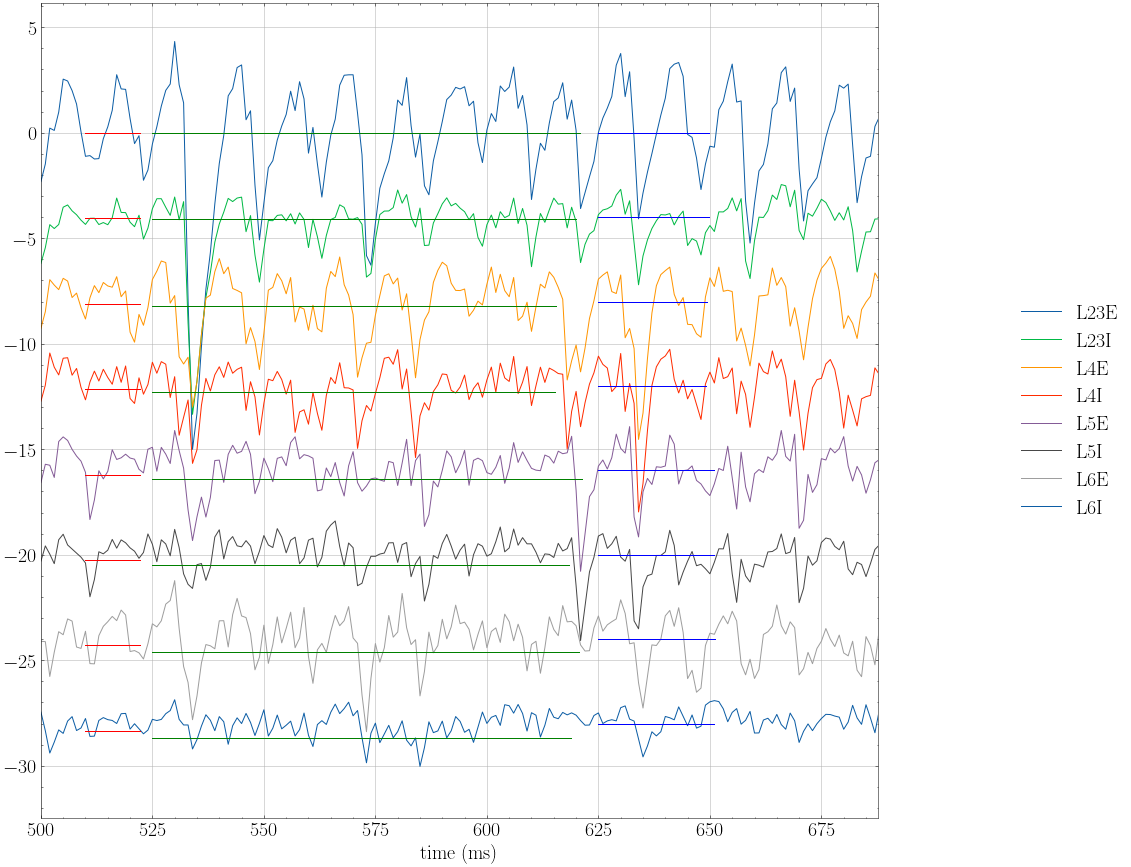

In [59]:
names= ['L23E','L23I','L4E','L4I','L5E','L5I','L6E','L6I']

voltage_freq = 82
voltage_period = 1 / 82 * 1000

plt.figure(figsize=(15,15))
for i, n in enumerate(data_voltages_2):
    plt.plot(data_voltages_2[i] - 4 * i,label = names[i])
    plt.plot((625,625+periods_gamma[i]),(np.mean(data_voltages_2[i])- 4*i,np.mean(data_voltages_2[i])- 4*i), color = 'blue')
    plt.plot((525,525+periods_alpha[i]),(np.mean(data_voltages_2[i])- 4.1*i,np.mean(data_voltages_2[i])- 4.1*i), color= 'green')
    plt.plot((510,510+voltage_period),(np.mean(data_voltages_2[i])- 4.05*i,np.mean(data_voltages_2[i])- 4.05*i), color = 'red')

plt.xlim(500,500 + mean_period_alpha * 2)
plt.grid()
plt.legend(bbox_to_anchor=(1.15,0.5))
plt.xlabel('time (ms)')

  Only spikes of neurons in steps of 1 are shown.
Directory already existed
Directory already existed


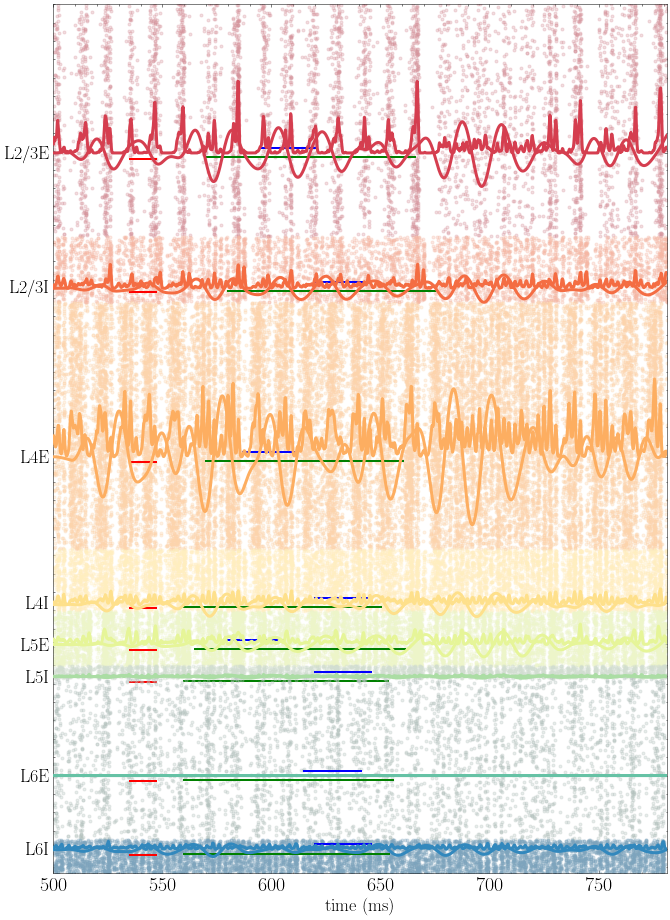

In [105]:


a = plot_raster('data_background_rate/08.13/','spike_recorder',raster_plot_interval[0],raster_plot_interval[1],1,M=[20,20,20,20,20,20,20,20],std=[1,1,1,1,1,1,1,1],period_alpha=periods_alpha,period_gamma=periods_gamma,binned=True,period_volt=voltage_period)

Text(0.5, 0, 'time (ms)')

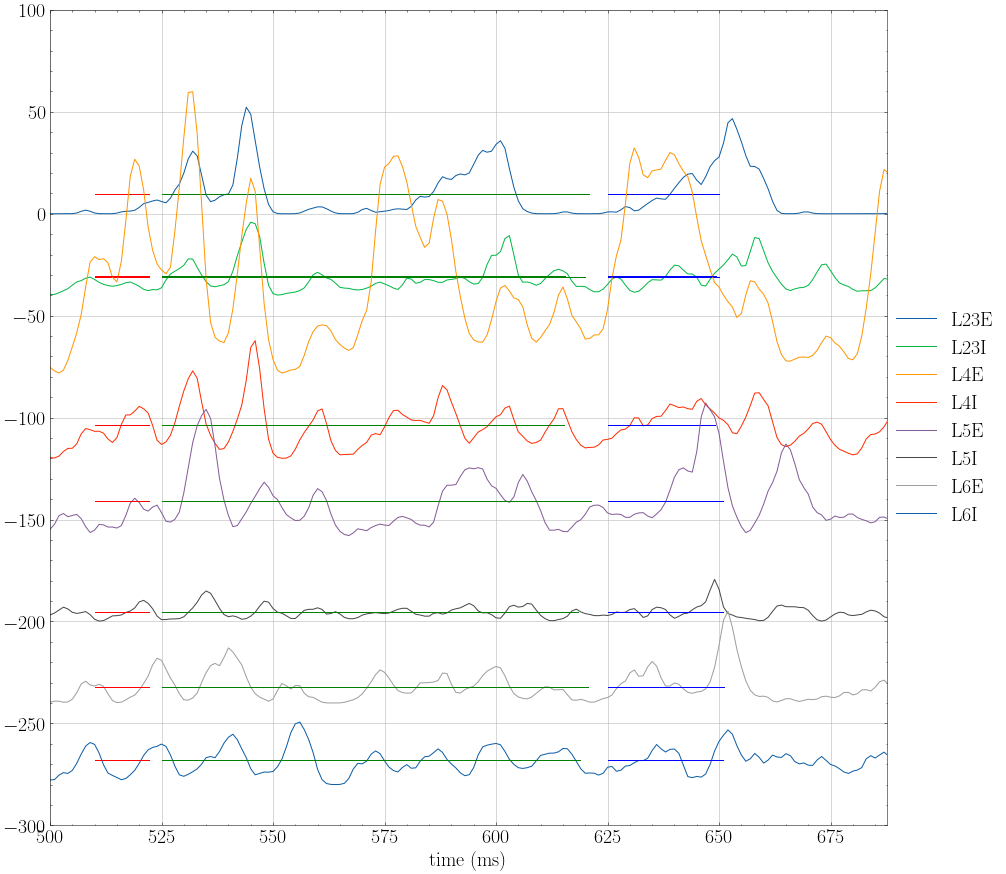

In [100]:
names= ['L23E','L23I','L4E','L4I','L5E','L5I','L6E','L6I']

voltage_freq = 82
voltage_period = 1 / 82 * 1000

plt.figure(figsize=(15,15))
for i, n in enumerate(pop_activity['08.13']):
    plt.plot(pop_activity['08.13'][i] - 40 * i,label = names[i])
    plt.plot((625,625+periods_gamma[i]),(np.mean(pop_activity['08.13'][i])- 40*i,np.mean(pop_activity['08.13'][i])- 40*i), color = 'blue')
    plt.plot((525,525+periods_alpha[i]),(np.mean(pop_activity['08.13'][i])- 40*i,np.mean(pop_activity['08.13'][i])- 40*i), color= 'green')
    plt.plot((510,510+voltage_period),(np.mean(pop_activity['08.13'][i])- 40*i,np.mean(pop_activity['08.13'][i])- 40*i), color = 'red')

plt.xlim(500,500 + mean_period_alpha * 2)
plt.ylim(-300,100)
plt.grid()
plt.legend(bbox_to_anchor=(1.15,0.5))
plt.xlabel('time (ms)')

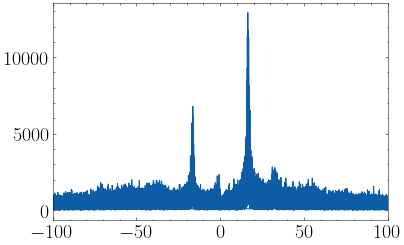

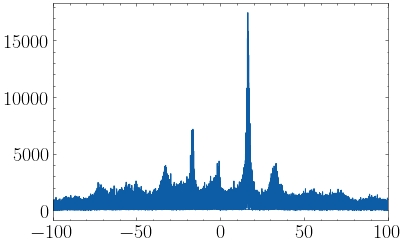

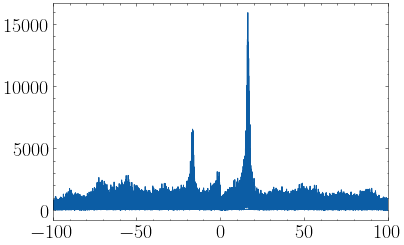

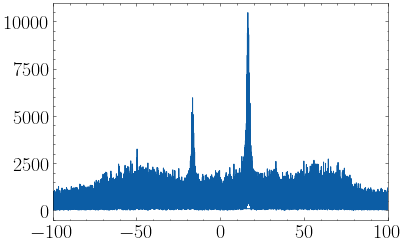

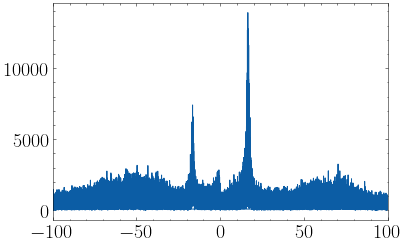

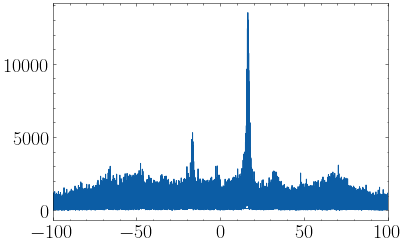

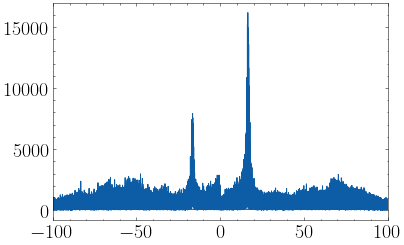

In [146]:
base_layer = 0

CFC_s = {}
frequencies_base = {}
frequencies_2 = {}

signal_hilbert = {}

filter_low = 0
filter_high = 88


CFC_s[i] = {}
frequencies_base[i] = {}
frequencies_2[i] = {}
for j, m in enumerate(pop_activity['08.13']):
    signal_hilbert_b = hilbert_transform(pop_activity['08.13'][base_layer])
    if j != base_layer:
        signal_hilbert_2 = hilbert_transform(pop_activity['08.13'][j])
        help = np.fft.fft(signal_hilbert_b)
        W = np.fft.fftfreq(len(signal_hilbert_b),d=0.001)
        help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

        signal_base = np.fft.ifft(help)

        help = np.fft.fft(signal_hilbert_2)
        W = np.fft.fftfreq(len(signal_hilbert_2),d=0.001)
        help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

        signal_2 = np.fft.ifft(help)

        z = signal_base * np.conjugate(signal_2) / (np.abs(signal_base) * np.abs(signal_2))
        welsh_power = np.abs(np.fft.fft(z-np.mean(z)))
        welsh_frequencies = np.fft.fftfreq(len(z),d=0.001)
        plt.plot(welsh_frequencies,welsh_power)
        plt.xlim(-100,100)
            #plt.xlim(1000,3000)
        plt.show()

0.10152225383497826


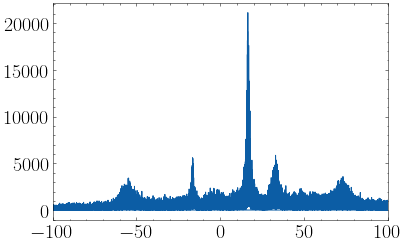

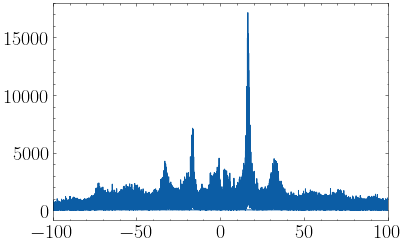

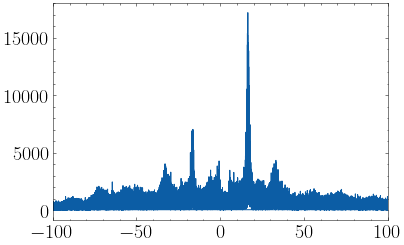

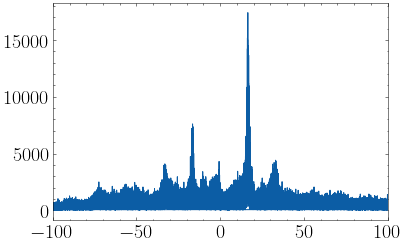

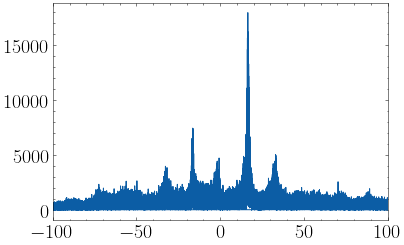

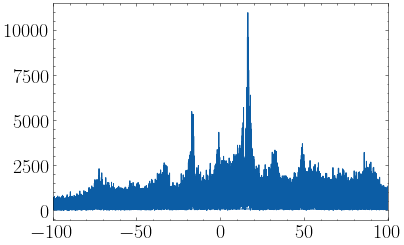

16.0


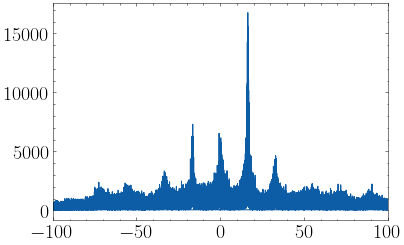

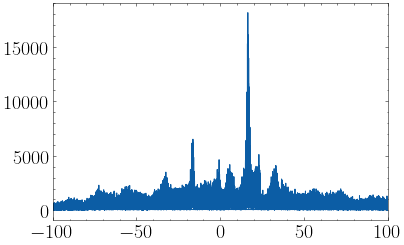

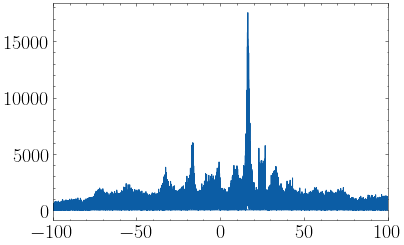

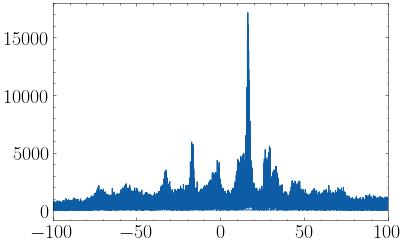

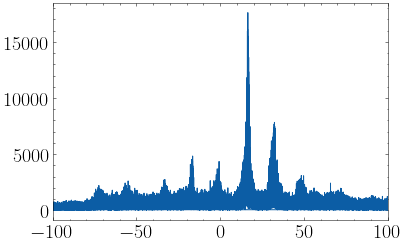

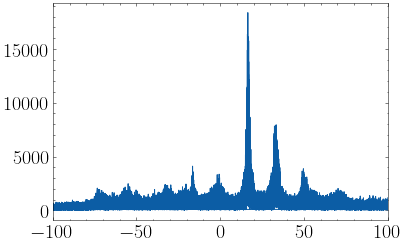

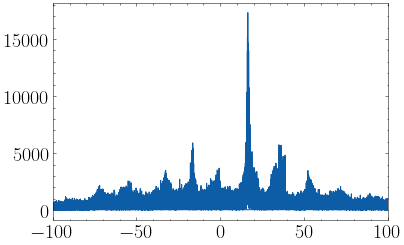

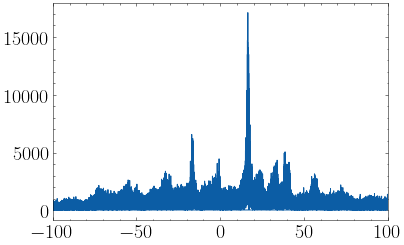

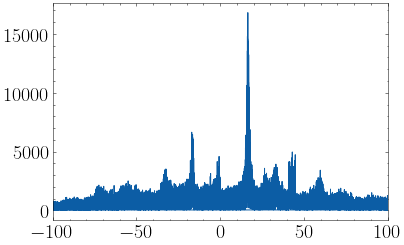

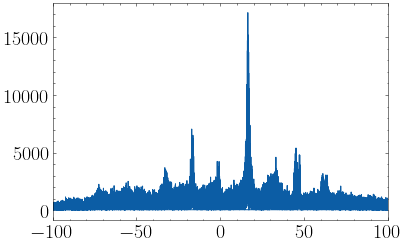

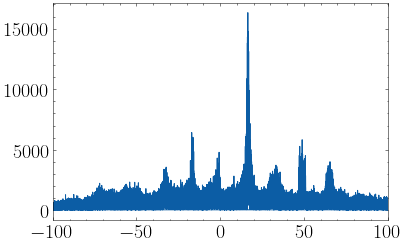

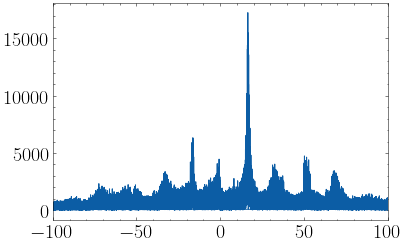

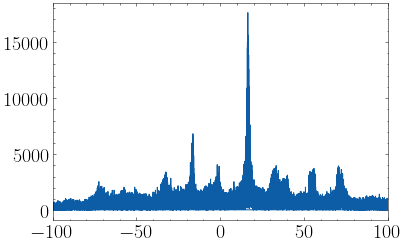

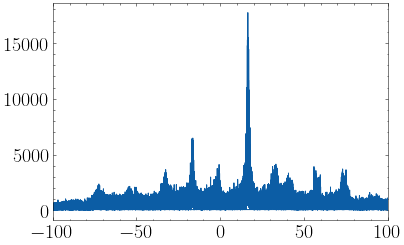

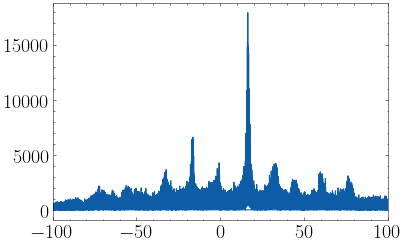

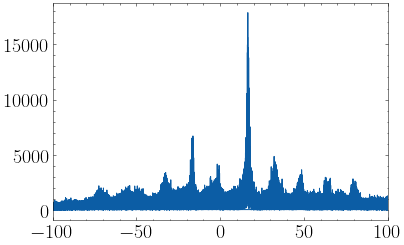

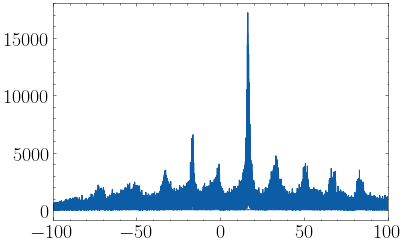

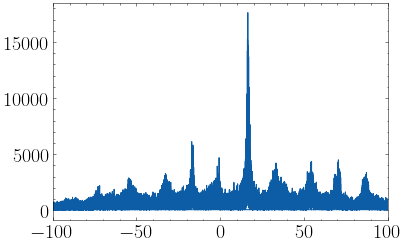

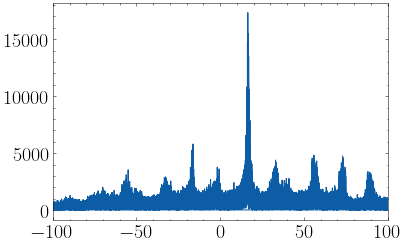

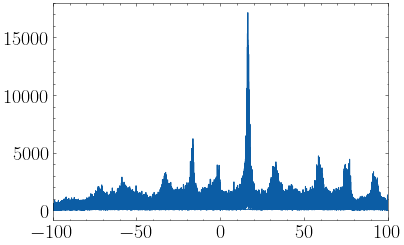

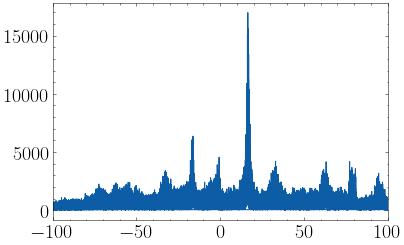

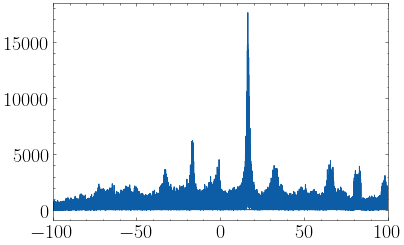

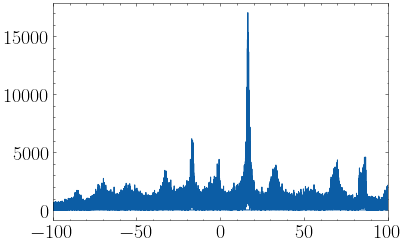

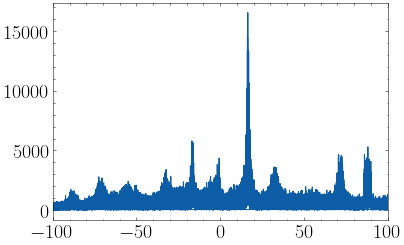

FREQUENCIES OF THE SECOND SIGNAL


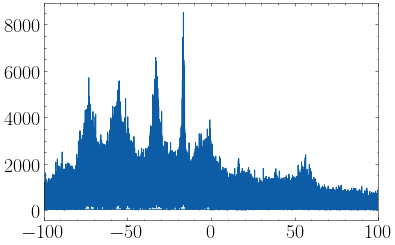

1.0


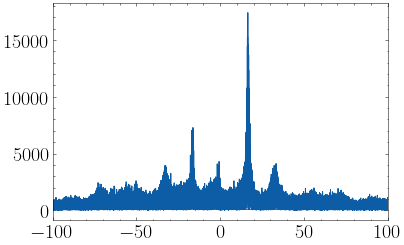

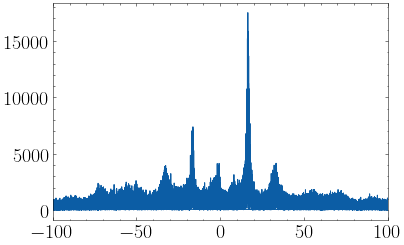

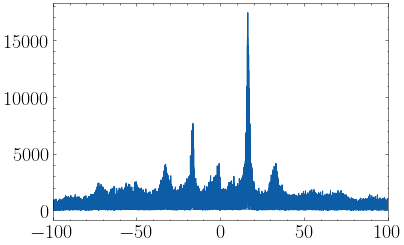

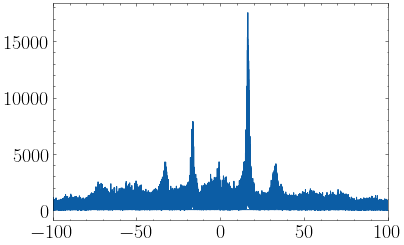

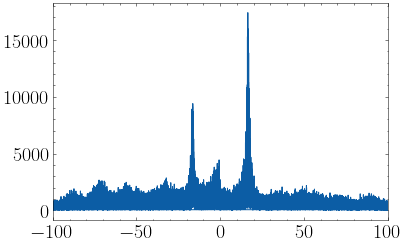

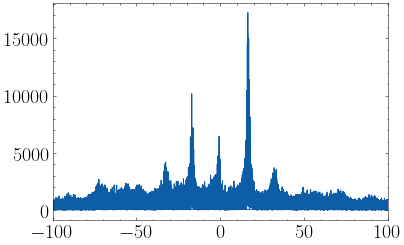

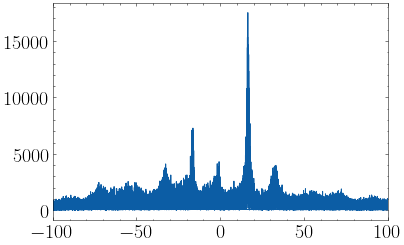

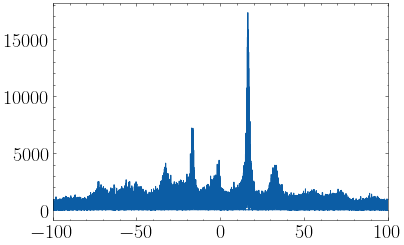

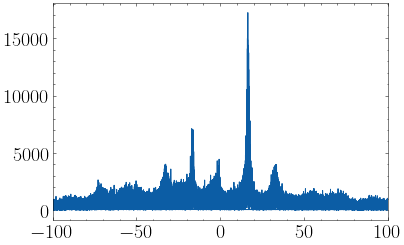

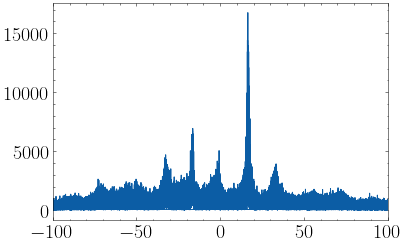

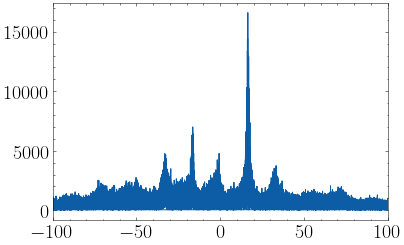

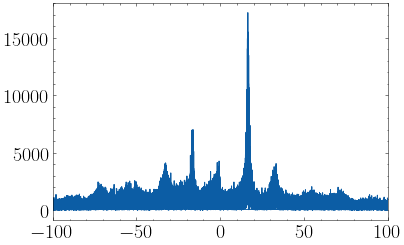

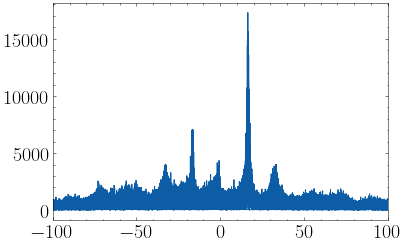

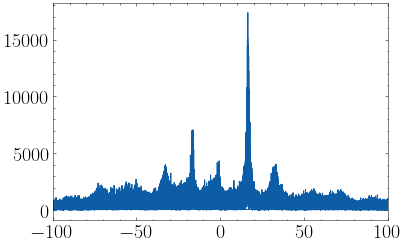

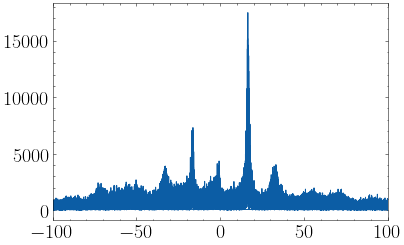

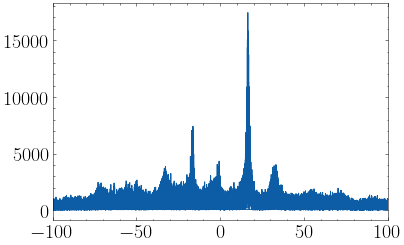

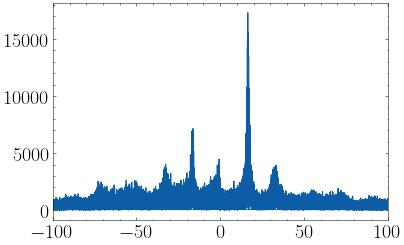

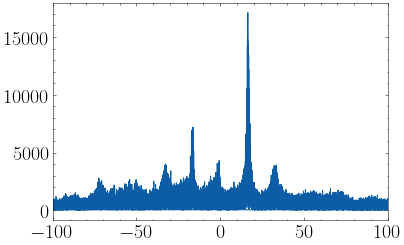

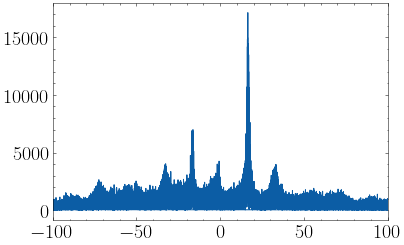

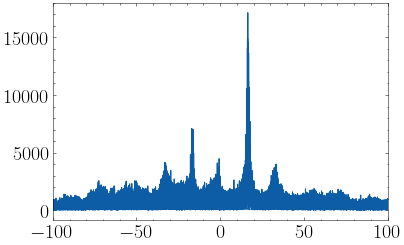

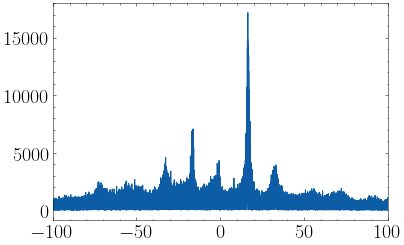

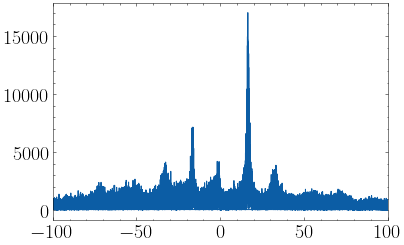

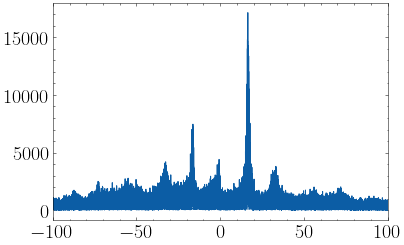

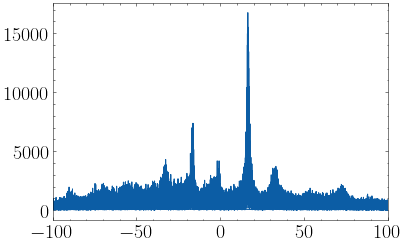

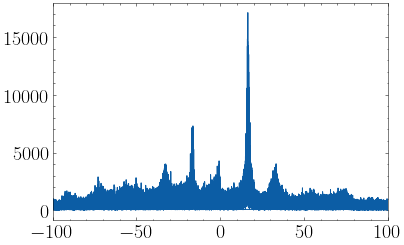

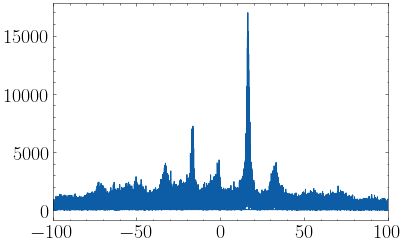

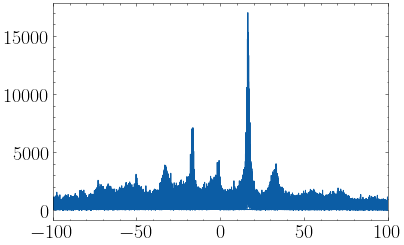

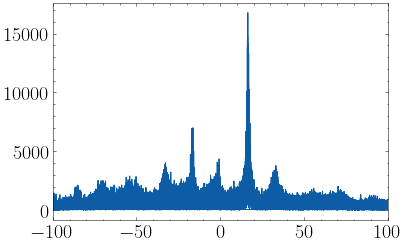

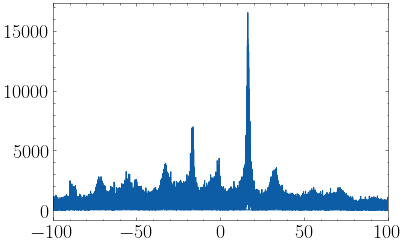

In [204]:
signal_hilbert_b = hilbert_transform(pop_activity['08.13'][base_layer])

signal_hilbert_2 = hilbert_transform(pop_activity['08.13'][2])
help = np.fft.fft(signal_hilbert_b)
W = np.fft.fftfreq(len(signal_hilbert_b),d=0.001)
help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

signal_base = np.fft.ifft(help)

help = np.fft.fft(signal_hilbert_2)
W = np.fft.fftfreq(len(signal_hilbert_2),d=0.001)
help[(np.abs(W)<filter_low) &  (np.abs(W)>filter_high) ] = 0

signal_2 = np.fft.ifft(help)

z = signal_base * np.conjugate(signal_2) / (np.abs(signal_base) * np.abs(signal_2))
welsh_power = np.abs(np.fft.fft(z-np.mean(z)))
welsh_frequencies = np.fft.fftfreq(len(z),d=0.001)
maximum = np.max(welsh_power)
padding = 3
distance = np.abs(welsh_frequencies[0] - welsh_frequencies[1])

point = np.argwhere(welsh_power==maximum)[0][0] 

central_freq = welsh_frequencies[point]
start = point-int(padding/distance)

stop = point+int(padding/distance)
if stop > len(welsh_frequencies):
    stop = len(welsh_frequencies) -1

num = int((-start +stop)/distance)
base_point_list = np.linspace(start,stop,num)
base_point_list = base_point_list.astype(int)

if central_freq + padding > 0 and central_freq < 0:
    support_freqs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    base_point_list = np.append(base_point_list,support_freqs)
    freqs_plots = welsh_frequencies[base_point_list]
    power_plot = welsh_power[base_point_list]
elif central_freq - padding < 0  and central_freq >0 :
    help = np.argwhere(welsh_frequencies<0)[0][0]
    support_freqs = [help,help+1,help+2,help+3,help+4,help+5,help+6,help+7,help+8,help+9,help+10,help+11,help+12,help+13,help+14,help+15,help+16,help+17,help+18,help+19]
    base_point_list = np.append(base_point_list,support_freqs)
    freqs_plots = welsh_frequencies[base_point_list]
    power_plot = welsh_power[base_point_list]
else:
    freqs_plots = welsh_frequencies[base_point_list]
    power_plot = welsh_power[base_point_list]

#plt.plot(freqs_plots,power_plot)
#plt.show()

int_num = np.trapz(power_plot,x=freqs_plots)
int_dem = np.trapz(welsh_power,x=welsh_frequencies)
CFC = int_num / int_dem

print(CFC)


frequencies = np.linspace(1,88,num=30)
sigma = 2
for l in frequencies:
    lowcut = l - sigma
    highcut = l + sigma
    help = np.fft.fft(signal_base)
    W = np.fft.fftfreq(len(signal_base),d=0.001)
    help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

    filtered_signal = np.fft.ifft(help)


    test_z = filtered_signal * np.conjugate(signal_2) / (np.abs(filtered_signal) * np.abs(signal_2))

    welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
    welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

    maximum_new = np.max(welsh_power)
    point = np.argwhere(welsh_power==maximum_new)[0][0] 
    central_freq_new = welsh_frequencies[point]

    plt.plot(welsh_frequencies,welsh_power)
    plt.xlim(-100,100)
    plt.show()

    if maximum_new < maximum/1.2:
        print(l)
        #break
        # 

print('FREQUENCIES OF THE SECOND SIGNAL')

for l in frequencies:
    lowcut = l - sigma
    highcut = l + sigma
    help = np.fft.fft(signal_2)
    W = np.fft.fftfreq(len(signal_2),d=0.001)
    help[(np.abs(W)<highcut) &  (np.abs(W)>lowcut) ] = 0

    filtered_signal = np.fft.ifft(help)


    test_z = signal_base * np.conjugate(filtered_signal) / (np.abs(filtered_signal) * np.abs(signal_base))

    welsh_power = np.abs(np.fft.fft(test_z-np.mean(test_z)))
    welsh_frequencies = np.fft.fftfreq(len(test_z),d=0.001)

    maximum_new = np.max(welsh_power)
    point = np.argwhere(welsh_power==maximum_new)[0][0] 
    central_freq_new = welsh_frequencies[point]
    
    plt.plot(welsh_frequencies,welsh_power)
    plt.xlim(-100,100)
    plt.show()
    if maximum_new < maximum/1.2:
        print(l)
        #break 
            